                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  138
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -529.774
Date:                Fri, 10 Oct 2025   AIC                           1067.548
Time:                        09:49:31   BIC                           1079.169
Sample:                    04-30-2013   HQIC                          1072.270
                         - 09-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ad_spend       1.6626      0.316      5.265      0.000       1.044       2.282
ar.L1          0.6135      0.030     20.280      0.000       0.554       0.673
ma.L1         -0.7684      0.065    -11.753      0.0

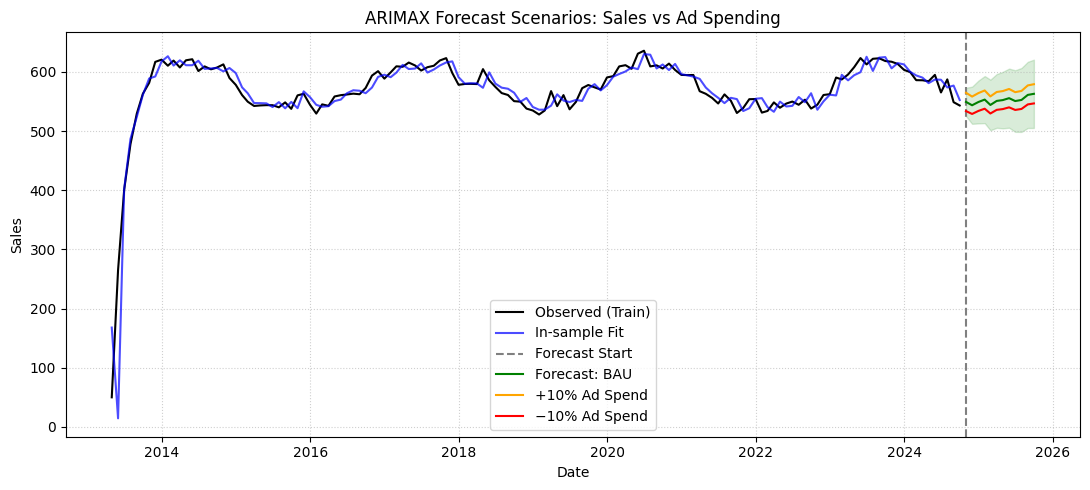


Average forecast difference:
  +10% ad spend → +15.28 units of sales
  −10% ad spend → -15.28 units of sales


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

np.random.seed(42)

# ------------------------------
# 1. Simulate Sales–Advertising Relationship
# ------------------------------
n = 150
time = np.arange(n)

# Advertising spend (slowly varying)
ad_spend = 100 + 10*np.sin(time/6) + np.random.normal(0, 2, n)

# Sales driven by ad spend + AR(1) + noise
sales = 50 + 0.6*np.roll(sales:=np.zeros(n), 1)  # predefine variable
for t in range(1, n):
    sales[t] = 50 + 0.6*sales[t-1] + 1.8*ad_spend[t] + np.random.normal(0, 10)

# Construct DataFrame
df = pd.DataFrame({'sales': sales, 'ad_spend': ad_spend},
                  index=pd.date_range(end=dt.date.today(), periods=n, freq='ME'))

train, test = df.iloc[:-12].copy(), df.iloc[-12:]

# ------------------------------
# 2. Fit ARIMAX model
# ------------------------------
model = SARIMAX(train['sales'],
                order=(1,1,1),
                exog=train[['ad_spend']],
                enforce_stationarity=False,
                enforce_invertibility=False)
res = model.fit(disp=False)
print(res.summary())

# In-sample fitted values
train['fitted'] = res.fittedvalues.reindex(train.index)

# ------------------------------
# 3. Prepare Forecast Scenarios
# ------------------------------
exog_future_bau = test[['ad_spend']].copy()
exog_future_up  = test[['ad_spend']] * 1.10   # +10% ad spend
exog_future_down= test[['ad_spend']] * 0.90   # -10% ad spend

# Forecasts
fc_bau  = res.get_forecast(steps=12, exog=exog_future_bau)
fc_up   = res.get_forecast(steps=12, exog=exog_future_up)
fc_down = res.get_forecast(steps=12, exog=exog_future_down)

# Extract predicted means
bau_mean  = fc_bau.predicted_mean
up_mean   = fc_up.predicted_mean
down_mean = fc_down.predicted_mean
ci        = fc_bau.conf_int()

# ------------------------------
# 4. Plot In-Sample + Scenario Forecasts
# ------------------------------
plt.figure(figsize=(11,5))
plt.plot(train.index, train['sales'], label='Observed (Train)', color='black')
plt.plot(train.index, train['fitted'], label='In-sample Fit', color='blue', alpha=0.7)
plt.axvline(test.index[0], color='gray', linestyle='--', label='Forecast Start')

# Forecast scenarios
plt.plot(bau_mean.index, bau_mean, color='green', label='Forecast: BAU')
plt.plot(up_mean.index, up_mean, color='orange', label='+10% Ad Spend')
plt.plot(down_mean.index, down_mean, color='red', label='−10% Ad Spend')

plt.fill_between(bau_mean.index, ci.iloc[:,0], ci.iloc[:,1], color='green', alpha=0.15)
plt.title("ARIMAX Forecast Scenarios: Sales vs Ad Spending")
plt.xlabel("Date"); plt.ylabel("Sales")
plt.legend(); plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

# ------------------------------
# 5. Show average forecast difference
# ------------------------------
impact_up = up_mean.mean() - bau_mean.mean()
impact_down = down_mean.mean() - bau_mean.mean()
print(f"\nAverage forecast difference:")
print(f"  +10% ad spend → +{impact_up:.2f} units of sales")
print(f"  −10% ad spend → {impact_down:.2f} units of sales")


                                     SARIMAX Results                                      
Dep. Variable:                             demand   No. Observations:                   72
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -144.583
Date:                            Fri, 10 Oct 2025   AIC                            301.165
Time:                                    10:05:30   BIC                            312.005
Sample:                                01-31-2019   HQIC                           305.207
                                     - 12-31-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
temp          -2.9504      0.563     -5.237      0.000      -4.055      -1.846
ar.L1          0.7126      0.027   

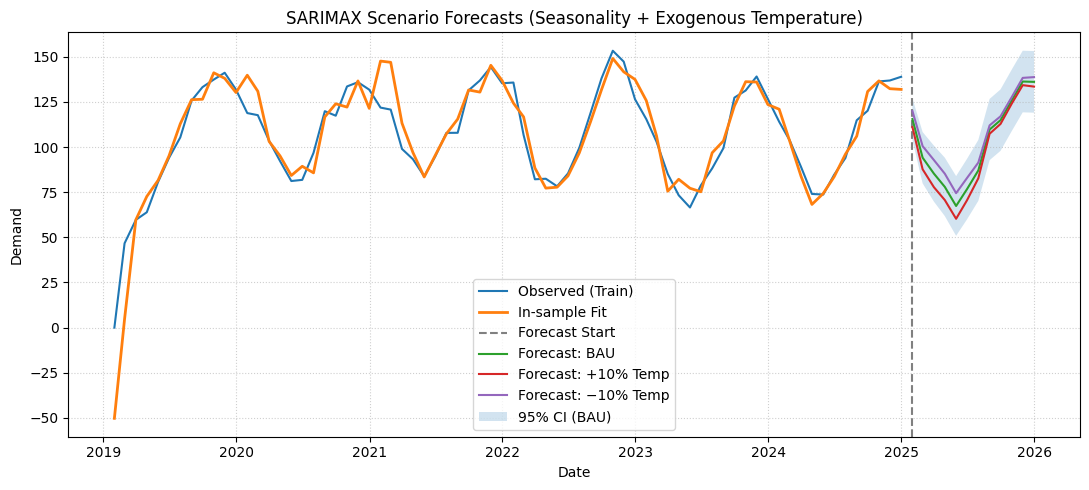


Average forecast impact vs BAU over the horizon:
  +10% Temp   → -4.51 demand units on average
  −10% Temp   → 4.51 demand units on average


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

np.random.seed(7)

# -------------------------------------------------
# 1) Simulate seasonal demand with an exogenous driver (temperature)
#    - Monthly frequency with seasonality (s=12)
#    - Demand decreases as temperature increases (typical heating load pattern)
# -------------------------------------------------
n = 84  # 7 years monthly -> stays within a realistic calendar window
date_idx = pd.date_range("2019-01-01", periods=n, freq="ME")
t = np.arange(n)

# Exogenous regressor: temperature with annual seasonality + noise
temp = 15 + 10*np.sin(2*np.pi*t/12) + np.random.normal(0, 1.2, n)

# True DGP (generative): seasonal component + AR + temp effect + noise
demand = np.zeros(n)
seasonal = 12*np.sin(2*np.pi*t/12)  # seasonal pattern in demand (independent of temp)
for i in range(1, n):
    demand[i] = (
        100
        + 0.5*demand[i-1]        # AR(1)
        - 3.0*temp[i]            # negative temp effect: colder -> higher demand
        + seasonal[i]
        + np.random.normal(0, 5)
    )

df = pd.DataFrame({"demand": demand, "temp": temp}, index=date_idx)

# -------------------------------------------------
# 2) Train/test split (last 12 months as forecast horizon)
#    Use .copy() to avoid SettingWithCopyWarning when adding columns
# -------------------------------------------------
train = df.iloc[:-12].copy()
test  = df.iloc[-12:].copy()

# -------------------------------------------------
# 3) Fit SARIMAX(demand ~ temp) with seasonality (s=12)
#    Use (1,1,1)x(1,1,1,12) as a reasonable default for demo
# -------------------------------------------------
model = SARIMAX(
    endog=train["demand"],
    exog=train[["temp"]],
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False,
)
res = model.fit(disp=False)
print(res.summary())

# In-sample 1-step-ahead fitted values (aligned to index)
train.loc[:, "fitted"] = res.fittedvalues.reindex(train.index)

# -------------------------------------------------
# 4) Build scenario exogenous paths for forecast window
#    BAU = original temp; UP/DOWN = +/-10% temp for scenario sensitivity
# -------------------------------------------------
exog_bau   = test[["temp"]].copy()
exog_up10  = test[["temp"]].copy() * 1.10   # +10% temp
exog_dn10  = test[["temp"]].copy() * 0.90   # -10% temp

# Forecast under each scenario
fc_bau  = res.get_forecast(steps=len(test), exog=exog_bau)
fc_up   = res.get_forecast(steps=len(test), exog=exog_up10)
fc_down = res.get_forecast(steps=len(test), exog=exog_dn10)

bau_mean  = fc_bau.predicted_mean
up_mean   = fc_up.predicted_mean
down_mean = fc_down.predicted_mean
ci_bau    = fc_bau.conf_int(alpha=0.05)  # 95% CI for BAU

# -------------------------------------------------
# 5) Plot: ex-ante style (NO observed beyond train)
#    - Observed (train) + in-sample fit
#    - 3 scenario forecasts only in test window
# -------------------------------------------------
plt.figure(figsize=(11, 5))

# In-sample observed and fitted
plt.plot(train.index, train["demand"], label="Observed (Train)")
plt.plot(train.index, train["fitted"], label="In-sample Fit", linewidth=2)

# Forecast start marker
plt.axvline(test.index[0], color="gray", linestyle="--", label="Forecast Start")

# Scenarios (forecast only)
plt.plot(bau_mean.index,  bau_mean.values,  label="Forecast: BAU")
plt.plot(up_mean.index,   up_mean.values,   label="Forecast: +10% Temp")
plt.plot(down_mean.index, down_mean.values, label="Forecast: −10% Temp")

# CI for BAU
plt.fill_between(
    bau_mean.index,
    ci_bau.iloc[:, 0].values,
    ci_bau.iloc[:, 1].values,
    alpha=0.2,
    label="95% CI (BAU)",
)

plt.title("SARIMAX Scenario Forecasts (Seasonality + Exogenous Temperature)")
plt.xlabel("Date"); plt.ylabel("Demand")
plt.legend()
plt.grid(True, linestyle=":", alpha=0.6)
plt.tight_layout()
plt.show()

# -------------------------------------------------
# 6) Report average scenario impact vs BAU
# -------------------------------------------------
impact_up   = (up_mean - bau_mean).mean()
impact_down = (down_mean - bau_mean).mean()
print("\nAverage forecast impact vs BAU over the horizon:")
print(f"  +10% Temp   → {impact_up:.2f} demand units on average")
print(f"  −10% Temp   → {impact_down:.2f} demand units on average")

# Optional: If your real driver is better scaled for % changes (e.g., ad spend),
# just replace 'temp' with that exog series and keep the +/- 10% logic.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     1556.
Date:                Wed, 08 Oct 2025   Prob (F-statistic):          2.55e-120
Time:                        20:09:22   Log-Likelihood:                -878.03
No. Observations:                 300   AIC:                             1760.
Df Residuals:                     298   BIC:                             1767.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8641      0.517     -1.670      0.0

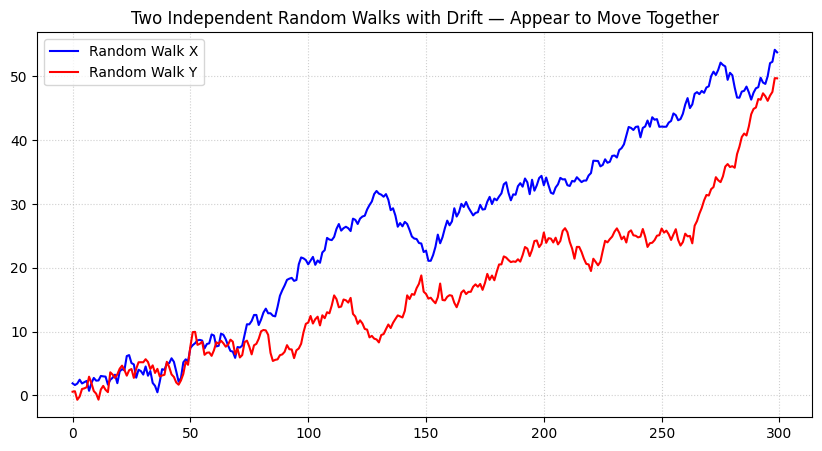

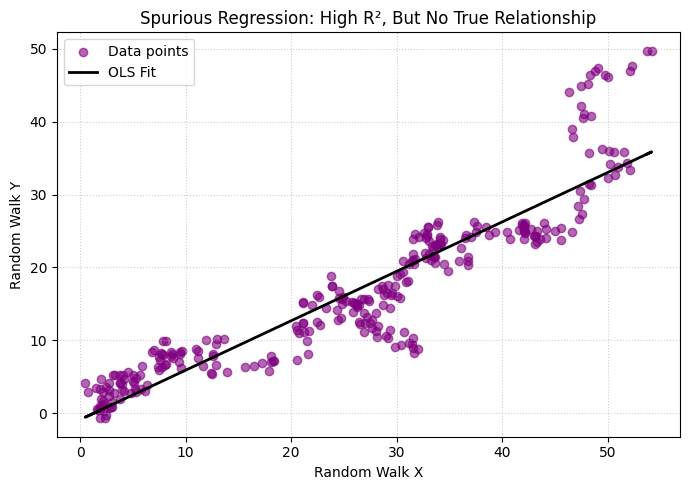

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

np.random.seed(7)
n = 300

# Create two unrelated random walks with similar drift
x = np.cumsum(np.random.normal(0.2, 1, n))
y = np.cumsum(np.random.normal(0.25, 1, n))

X = sm.add_constant(x)
model = sm.OLS(y, X).fit()

print(model.summary())

r2 = model.rsquared
pval = model.pvalues[1]

print(f"\n=== Spurious Regression Diagnostic ===")
print(f"R²: {r2:.3f}")
print(f"p-value for β₁: {pval:.4f}")
if pval < 0.05:
    print("→ Looks 'significant' ❌ (but it's fake — both series are random walks!)")
else:
    print("→ Not significant ✅ (no spurious effect this draw)")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(x, label="Random Walk X", color="blue")
plt.plot(y, label="Random Walk Y", color="red")
plt.title("Two Independent Random Walks with Drift — Appear to Move Together")
plt.legend()
plt.grid(True, linestyle=":", alpha=0.6)
plt.show()

plt.figure(figsize=(7, 5))
plt.scatter(x, y, alpha=0.6, color="purple", label="Data points")
plt.plot(x, model.predict(X), color="black", lw=2, label="OLS Fit")
plt.title("Spurious Regression: High R², But No True Relationship")
plt.xlabel("Random Walk X")
plt.ylabel("Random Walk Y")
plt.legend()
plt.grid(True, linestyle=":", alpha=0.6)
plt.tight_layout()
plt.show()



===== Spurious (independent random walks) =====
EG (coint) statistic: -2.106 | p-value: 0.4733
2-step EG: ADF(residual) stat: -2.110 | p-value: 0.2404
→ No cointegration (likely spurious) ❌.


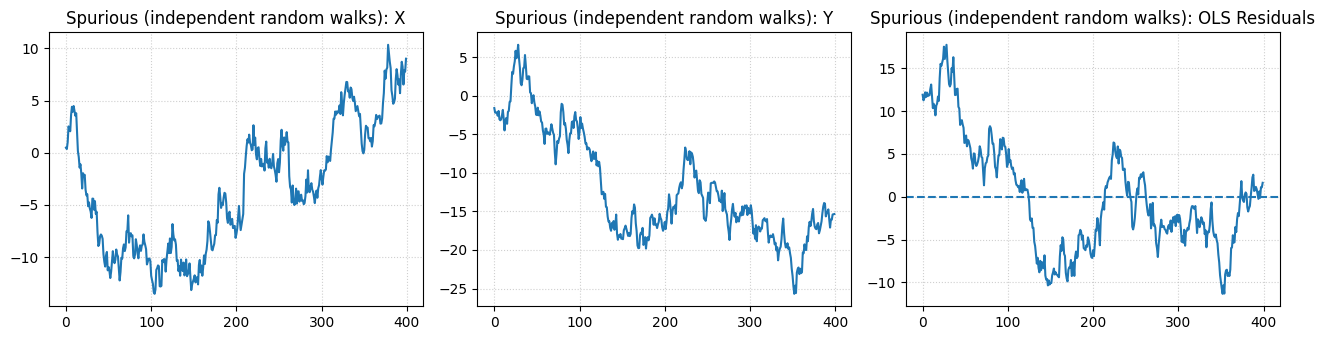


===== Cointegrated (y ≈ 2x + noise) =====
EG (coint) statistic: -19.131 | p-value: 0.0000
2-step EG: ADF(residual) stat: -19.107 | p-value: 0.0000
→ Cointegration detected ✅ (reject unit-root in residuals).


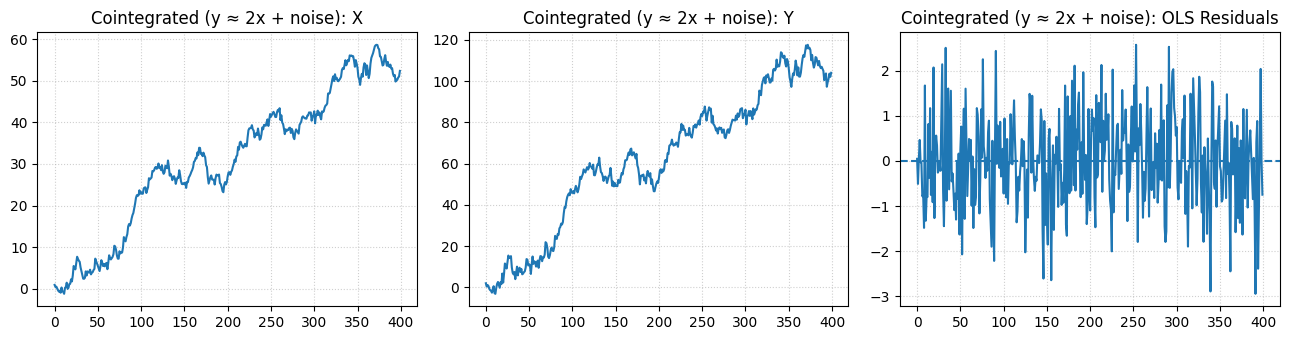

In [2]:
# engle_granger_demo.py
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

np.random.seed(42)
n = 400

# ----------------------------
# Helpers
# ----------------------------
def eg_two_step(y, x, with_const=True):
    """Engle-Granger 2-step: OLS y~x, then ADF on residuals."""
    X = sm.add_constant(x) if with_const else x
    ols = sm.OLS(y, X).fit()
    resid = ols.resid
    adf_stat, pval, *_ = adfuller(resid, autolag="AIC")  # H0: residuals have unit root (not cointegrated)
    return ols, resid, adf_stat, pval

def report_case(name, y, x):
    print(f"\n===== {name} =====")
    # 1) Engle–Granger test (one-shot)
    stat, pval, crit = coint(y, x, trend='c')  # trend='c' allows intercept in cointegrating relation
    print(f"EG (coint) statistic: {stat:.3f} | p-value: {pval:.4f}")
    # 2) Two-step EG
    ols, resid, adf_stat, adf_p = eg_two_step(y, x, with_const=True)
    print(f"2-step EG: ADF(residual) stat: {adf_stat:.3f} | p-value: {adf_p:.4f}")
    # Decision hints
    if pval < 0.05 and adf_p < 0.05:
        print("→ Cointegration detected ✅ (reject unit-root in residuals).")
    else:
        print("→ No cointegration (likely spurious) ❌.")

    # Plots
    fig, axes = plt.subplots(1, 3, figsize=(13, 3.5))
    axes[0].plot(x); axes[0].set_title(f"{name}: X")
    axes[1].plot(y); axes[1].set_title(f"{name}: Y")
    axes[2].plot(resid); axes[2].axhline(0, linestyle="--")
    axes[2].set_title(f"{name}: OLS Residuals")
    for ax in axes:
        ax.grid(True, linestyle=":", alpha=0.6)
    plt.tight_layout(); plt.show()

# ----------------------------
# Case A: Spurious regression (no cointegration)
# Two independent random walks
# ----------------------------
xA = np.cumsum(np.random.normal(size=n))
yA = np.cumsum(np.random.normal(size=n))
report_case("Spurious (independent random walks)", yA, xA)

# ----------------------------
# Case B: Cointegrated series
# x: random walk; y: 2*x + stationary noise + small drift in y (intercept handled)
# Residual y - beta*x is stationary
# ----------------------------
xB = np.cumsum(np.random.normal(size=n))
eps = np.random.normal(scale=1.0, size=n)     # stationary noise
yB = 2.0 * xB + eps
report_case("Cointegrated (y ≈ 2x + noise)", yB, xB)


Best Engle–Granger p-value: 0.0006143 for pair MA / V
Hedge ratio β=1.7573, intercept α=-29.7538

Pair used: MA / V
CAGR   : 2.62%
Sharpe : 0.25
Max DD : -28.24%
Trades : 125 | Win rate (nonzero days): 49.96%


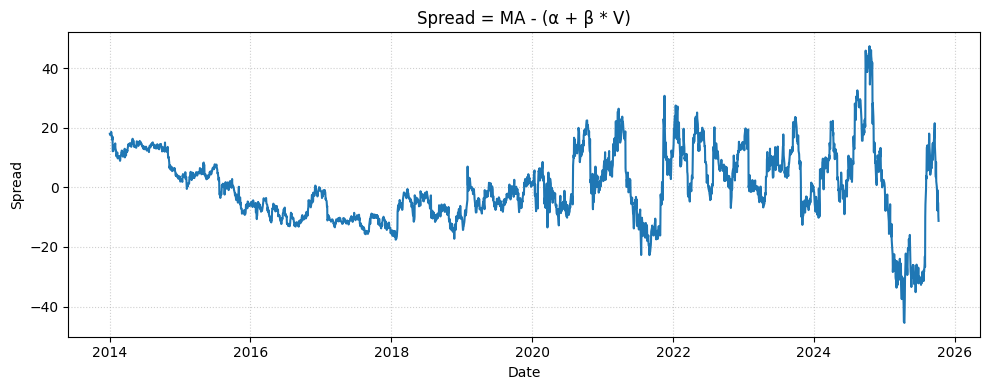

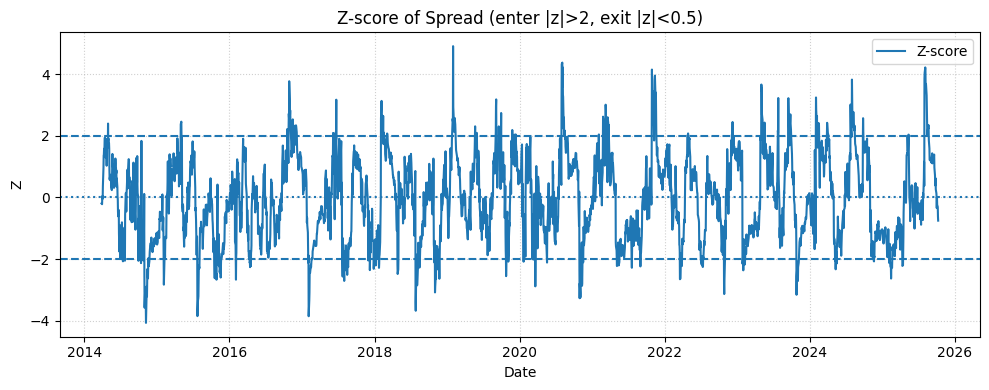

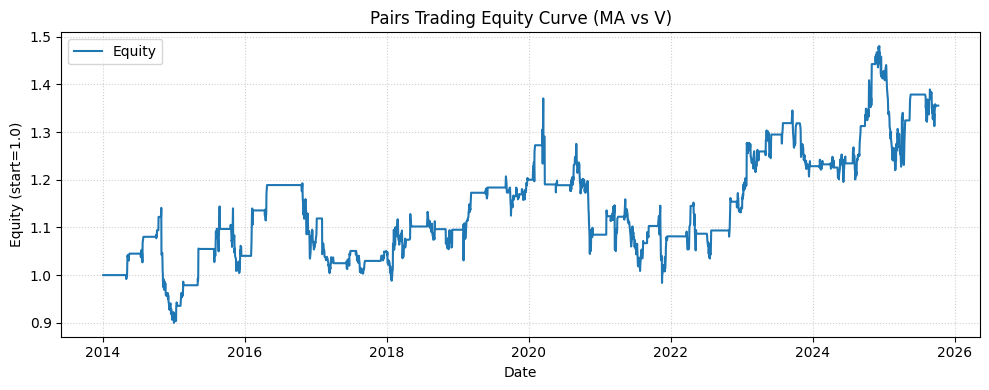

In [6]:
# pairs_trading_cointegration_demo.py
# - Pick the best cointegrated pair from a candidate list of DIFFERENT companies
# - Build a basic pairs strategy (z-score of spread)
# - Plot signals & equity; report performance

# pip install yfinance statsmodels pandas numpy matplotlib --quiet

import itertools
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt

# -----------------------
# 1) Settings & Data
# -----------------------
candidates = ["XOM","CVX","KO","PEP","V","MA","JPM","BAC","F","GM"]  # different firms
start = "2014-01-01"
end   = None

px = yf.download(candidates, start=start, end=end, auto_adjust=True, progress=False)["Close"].dropna(how="all")
px = px.dropna(axis=0)  # drop any leading NaNs

# Keep columns present throughout
px = px.dropna(axis=1)
tickers = list(px.columns)

# -----------------------
# 2) Find best cointegrated pair
# -----------------------
results = []
for a, b in itertools.combinations(tickers, 2):
    y, x = px[a].dropna(), px[b].dropna()
    common = y.index.intersection(x.index)
    y, x = y.loc[common], x.loc[common]
    if len(common) < 252:  # at least ~1y
        continue
    stat, pval, _ = coint(y, x, trend="c")
    results.append((pval, a, b))

if not results:
    raise RuntimeError("No pairs to test. Check your ticker list/data window.")

results.sort()
best_pval, A, B = results[0]
print(f"Best Engle–Granger p-value: {best_pval:.4g} for pair {A} / {B}")
if best_pval >= 0.05:
    print("⚠️ No pair met the 5% cointegration threshold. Proceeding with the best available pair anyway.\n")

# Work with the best pair
y = px[A].dropna()
x = px[B].dropna()
common = y.index.intersection(x.index)
y, x = y.loc[common], x.loc[common]

# -----------------------
# 3) Hedge ratio via OLS and spread
# -----------------------
X = sm.add_constant(x)
beta_model = sm.OLS(y, X).fit()
alpha = beta_model.params["const"]
beta  = beta_model.params[B]
print(f"Hedge ratio β={beta:.4f}, intercept α={alpha:.4f}")

spread = y - (alpha + beta * x)

# -----------------------
# 4) Z-score strategy (rolling)
# -----------------------
lookback = 60
z = (spread - spread.rolling(lookback).mean()) / spread.rolling(lookback).std()

entry_z = 2.0
exit_z  = 0.5

state = 0        # 0=flat, +1=long spread, -1=short spread
pos_y = pd.Series(0.0, index=spread.index)  # position in A (y)
pos_x = pd.Series(0.0, index=spread.index)  # position in B (x), scaled by beta

for i in range(1, len(spread)):
    if np.isnan(z.iloc[i-1]):
        continue
    zt = z.iloc[i-1]

    # Exit rule
    if state != 0 and abs(zt) < exit_z:
        state = 0

    # Entry rule
    if state == 0:
        if zt > entry_z:
            state = -1  # short spread: short y, long beta*x
        elif zt < -entry_z:
            state = +1  # long spread: long y, short beta*x

    if state == +1:
        pos_y.iloc[i] = +1.0
        pos_x.iloc[i] = -beta
    elif state == -1:
        pos_y.iloc[i] = -1.0
        pos_x.iloc[i] = +beta
    else:
        pos_y.iloc[i] = 0.0
        pos_x.iloc[i] = 0.0

# No lookahead: apply from next bar
pos_y = pos_y.shift(1).fillna(0.0)
pos_x = pos_x.shift(1).fillna(0.0)

# -----------------------
# 5) P&L and metrics
# -----------------------
ret = pd.concat([y.pct_change(), x.pct_change()], axis=1).dropna()
ret.columns = [A, B]
pos_y = pos_y.reindex(ret.index).fillna(0.0)
pos_x = pos_x.reindex(ret.index).fillna(0.0)

# Optional simple costs per turnover
# cost_bps = 0.0005
# turnover = pos_y.diff().abs().fillna(0.0) + pos_x.diff().abs().fillna(0.0)
# strategy_ret = pos_y * ret[A] + pos_x * ret[B] - cost_bps*turnover

strategy_ret = pos_y * ret[A] + pos_x * ret[B]
equity = (1 + strategy_ret).cumprod()

def perf_stats(r, freq=252):
    r = r.dropna()
    cagr = (1 + r).prod() ** (freq / len(r)) - 1
    vol  = r.std() * np.sqrt(freq)
    sharpe = (r.mean() * freq) / (r.std() * np.sqrt(freq)) if r.std() > 0 else np.nan
    dd = (equity / equity.cummax() - 1).min()
    return cagr, sharpe, dd

cagr, sharpe, mdd = perf_stats(strategy_ret)
trades = ((pos_y != 0) & (pos_y.shift(1) == 0)).sum() + ((pos_y == 0) & (pos_y.shift(1) != 0)).sum()
nonzero_days = strategy_ret[strategy_ret != 0]
win_rate = (nonzero_days > 0).mean() if len(nonzero_days) else np.nan

print(f"\nPair used: {A} / {B}")
print(f"CAGR   : {cagr:.2%}")
print(f"Sharpe : {sharpe:.2f}")
print(f"Max DD : {mdd:.2%}")
print(f"Trades : {int(trades)} | Win rate (nonzero days): {win_rate:.2%}")

# -----------------------
# 6) Plots
# -----------------------
plt.figure(figsize=(10,4))
plt.plot(spread.index, spread.values)
plt.title(f"Spread = {A} - (α + β * {B})")
plt.xlabel("Date"); plt.ylabel("Spread")
plt.grid(True, linestyle=":", alpha=0.6)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
plt.plot(z.index, z.values, label="Z-score")
plt.axhline(entry_z, linestyle="--")
plt.axhline(-entry_z, linestyle="--")
plt.axhline(0.0, linestyle=":")
plt.title("Z-score of Spread (enter |z|>2, exit |z|<0.5)")
plt.xlabel("Date"); plt.ylabel("Z")
plt.legend(); plt.grid(True, linestyle=":", alpha=0.6)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
plt.plot(equity.index, equity.values, label="Equity")
plt.title(f"Pairs Trading Equity Curve ({A} vs {B})")
plt.xlabel("Date"); plt.ylabel("Equity (start=1.0)")
plt.legend(); plt.grid(True, linestyle=":", alpha=0.6)
plt.tight_layout(); plt.show()



=== Johansen test on A (cointegrated y ≈ 2x + noise) ===

Eigenvalues:
  lambda_1 = 0.3367
  lambda_2 = 0.0045

Trace test (H0: r <= r0):
  r0=0: stat=248.21 | cv95=15.49 -> Reject H0
  r0=1: stat=2.67 | cv95=3.84 -> Fail to reject H0

Max-eigen test (H0: r = r0):
  r0=0: stat=245.54 | cv95=14.26 -> Reject H0
  r0=1: stat=2.67 | cv95=3.84 -> Fail to reject H0

Cointegrating vectors (beta columns):
  beta_1: 1.441*y, -2.894*x
  beta_2: -0.010*y, 0.167*x


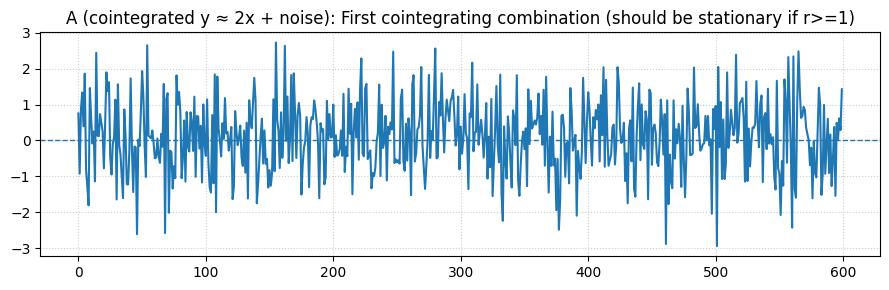


=== Johansen test on B (independent random walks) ===

Eigenvalues:
  lambda_1 = 0.0170
  lambda_2 = 0.0007

Trace test (H0: r <= r0):
  r0=0: stat=10.67 | cv95=15.49 -> Fail to reject H0
  r0=1: stat=0.43 | cv95=3.84 -> Fail to reject H0

Max-eigen test (H0: r = r0):
  r0=0: stat=10.24 | cv95=14.26 -> Fail to reject H0
  r0=1: stat=0.43 | cv95=3.84 -> Fail to reject H0

Cointegrating vectors (beta columns):
  beta_1: 0.004*u, 0.258*v
  beta_2: 0.066*u, -0.002*v


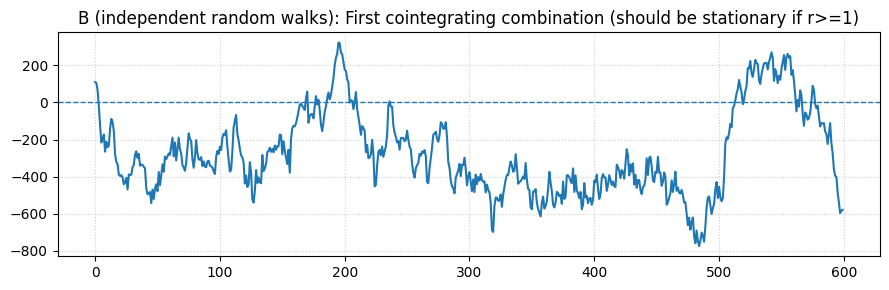

In [7]:
# johansen_demo.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import coint_johansen

np.random.seed(42)
n = 600

# --------- A) Build two I(1) series that ARE cointegrated ----------
x = np.cumsum(np.random.normal(scale=1.0, size=n))          # RW(1)
y = 2.0 * x + np.random.normal(scale=1.0, size=n)           # y ~ 2x + stationary noise
A = pd.DataFrame({"y": y, "x": x})

# --------- B) Build two I(1) series that are NOT cointegrated -----
u = np.cumsum(np.random.normal(scale=1.0, size=n))
v = np.cumsum(np.random.normal(scale=1.0, size=n))
B = pd.DataFrame({"u": u, "v": v})

def johansen_summary(df, det_order=0, k_ar_diff=1, name=""):
    """
    det_order:
      -1: no deterministic terms
       0: constant in cointegrating relations (most common)
       1: linear trend in cointegrating relations
       2: constant in VAR, etc.  (see statsmodels docs)
    k_ar_diff: number of lagged differences (p-1 in VAR(p))
    """
    print(f"\n=== Johansen test on {name} ===")
    res = coint_johansen(df.values, det_order=det_order, k_ar_diff=k_ar_diff)

    cols = list(df.columns)
    # Eigenvalues (strength of relations)
    print("\nEigenvalues:")
    for i, ev in enumerate(res.eig):
        print(f"  lambda_{i+1} = {ev:.4f}")

    # Trace test
    print("\nTrace test (H0: r <= r0):")
    for r0 in range(len(cols)):
        stat = res.lr1[r0]               # trace statistic for r0
        cv90, cv95, cv99 = res.cvt[r0]   # critical values at 90/95/99%
        decision = "Reject H0" if stat > cv95 else "Fail to reject H0"
        print(f"  r0={r0}: stat={stat:.2f} | cv95={cv95:.2f} -> {decision}")

    # Max-eigen test
    print("\nMax-eigen test (H0: r = r0):")
    for r0 in range(len(cols)):
        stat = res.lr2[r0]               # max-eigen statistic for r0
        cv90, cv95, cv99 = res.cvm[r0]
        decision = "Reject H0" if stat > cv95 else "Fail to reject H0"
        print(f"  r0={r0}: stat={stat:.2f} | cv95={cv95:.2f} -> {decision}")

    # Estimated cointegrating vectors (columns of res.evec)
    # Each column is a beta vector: beta' * y_t is (ideally) I(0)
    beta = res.evec
    print("\nCointegrating vectors (beta columns):")
    for j in range(beta.shape[1]):
        vec = ", ".join([f"{coef:.3f}*{col}" for coef, col in zip(beta[:, j], cols)])
        print(f"  beta_{j+1}: {vec}")

    # Optional: plot the first cointegrating relation (normalized so coefficient on first var = 1)
    b = beta[:, 0] / beta[0, 0]
    combo = df.values @ b
    plt.figure(figsize=(9,3))
    plt.plot(combo)
    plt.axhline(0, ls="--", lw=1)
    plt.title(f"{name}: First cointegrating combination (should be stationary if r>=1)")
    plt.grid(True, ls=":", alpha=0.6)
    plt.tight_layout()
    plt.show()

# Run on both datasets
johansen_summary(A, det_order=0, k_ar_diff=1, name="A (cointegrated y ≈ 2x + noise)")
johansen_summary(B, det_order=0, k_ar_diff=1, name="B (independent random walks)")



=== Stationarity: weekly log levels ===
ADF  log WTI     : stat=-2.299, p=0.1722, lags=10, n=772
KPSS log WTI      (c): stat=0.731, p=0.01075, lags=20
KPSS log WTI      (ct): stat=0.502, p=0.01, lags=20
ADF  log Brent   : stat=-1.945, p=0.3112, lags=12, n=770
KPSS log Brent    (c): stat=0.786, p=0.01, lags=20
KPSS log Brent    (ct): stat=0.482, p=0.01, lags=20

=== Stationarity: first differences (should be stationary) ===
ADF  Δlog WTI    : stat=-9.683, p=1.188e-16, lags=9, n=772
KPSS Δlog WTI     (c): stat=0.056, p=0.1, lags=20
ADF  Δlog Brent  : stat=-9.038, p=5.222e-15, lags=11, n=770
KPSS Δlog Brent   (c): stat=0.061, p=0.1, lags=20

=== Engle–Granger (weekly logs) ===
EG (const):       p=0.03181
EG (const+trend): p=0.049

=== Long-run OLS (WTI ~ 1 + Brent) ===
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0550      0.026      2.085      0.037       0.0

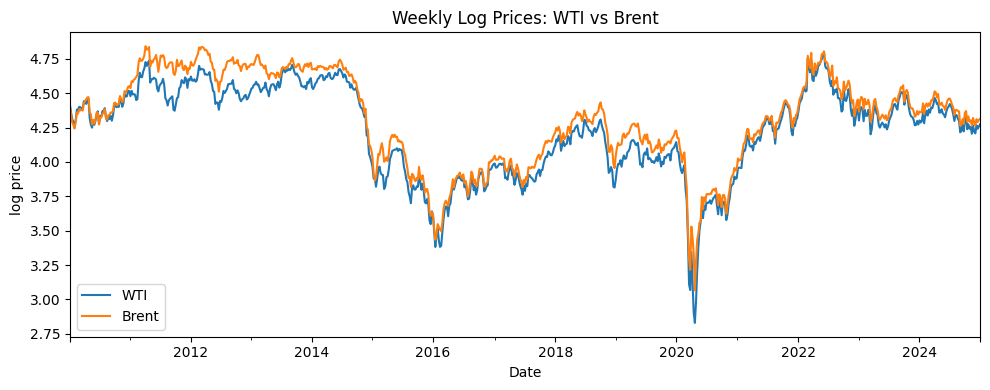

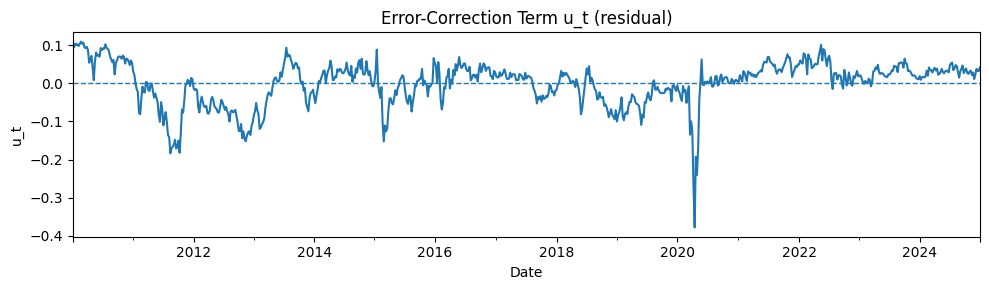

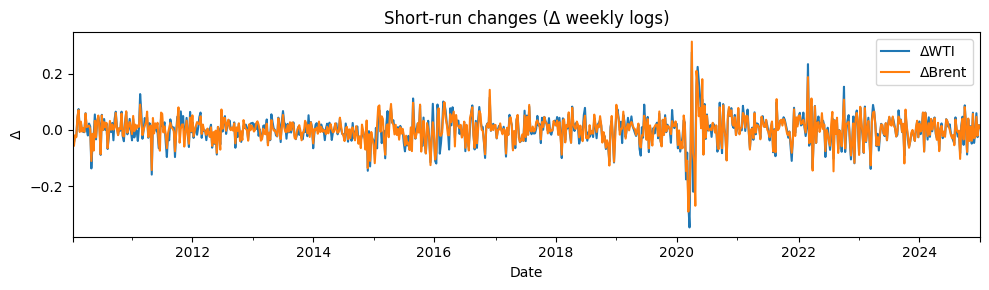

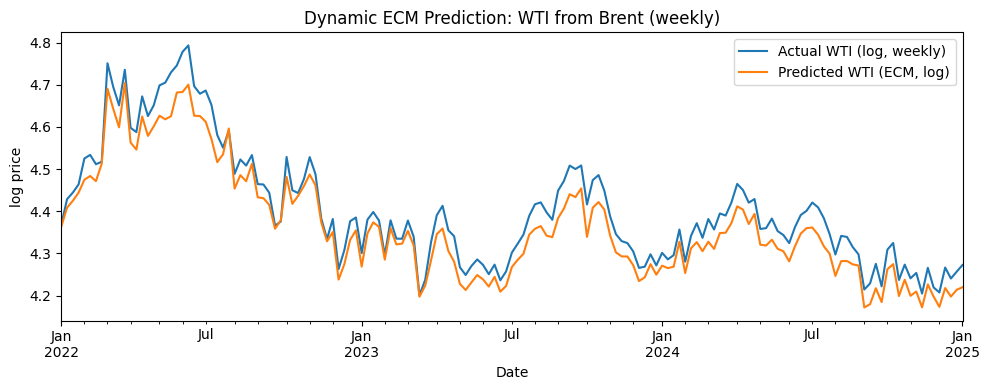

In [16]:
# Brent–WTI ECM with ADF, KPSS, Engle–Granger, ECM, and dynamic prediction (NO Johansen)
# pip install yfinance statsmodels pandas matplotlib

import warnings
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, coint, InterpolationWarning

plt.rcParams["figure.figsize"] = (10, 4)

# -----------------------------
# 0) Settings
# -----------------------------
Y_TICK, X_TICK = "CL=F", "BZ=F"   # WTI, Brent (futures continuous)
START, END     = "2010-01-01", "2025-01-01"
TRAIN_END      = "2021-12-31"     # train/test split (inclusive for train)

# -----------------------------
# 1) Download & prep (weekly)
# -----------------------------
raw = yf.download([Y_TICK, X_TICK], start=START, end=END, auto_adjust=True,
                  progress=False, group_by="ticker", threads=True)

def pick_close(frame, ticker):
    if isinstance(frame.columns, pd.MultiIndex):
        if "Close" in frame.columns.get_level_values(0):
            s = frame["Close"][ticker]
        elif "Close" in frame.columns.get_level_values(-1):
            s = frame.xs("Close", axis=1, level=-1)[ticker]
        else:
            raise KeyError("Close not found")
    else:
        s = frame["Close"] if "Close" in frame.columns else frame["Adj Close"]
    return s.dropna().rename(ticker)

Y_close = pick_close(raw, Y_TICK)
X_close = pick_close(raw, X_TICK)

daily = pd.concat([Y_close, X_close], axis=1).sort_index()
daily = daily.ffill().dropna()
weekly = daily.resample("W-FRI").last().dropna()
weekly.columns = ["WTI", "Brent"]

logp = np.log(weekly)
Y, X = logp["WTI"], logp["Brent"]

# -----------------------------
# 2) Stationarity tests: ADF + KPSS (level 'c' and trend 'ct')
# -----------------------------
def adf(label, s):
    stat, p, lags, n, *_ = adfuller(s.dropna(), autolag="AIC")
    print(f"ADF  {label:12s}: stat={stat:.3f}, p={p:.4g}, lags={lags}, n={n}")

def safe_kpss(label, s, regression="c"):
    n = s.dropna().shape[0]
    nlags = min(int(12 * (n/100.0)**0.25), max(n-1, 1))  # conservative cap
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=InterpolationWarning)
        try:
            stat, p, lags, _ = kpss(s.dropna(), regression=regression, nlags=nlags)
            print(f"KPSS {label:12s} ({regression}): stat={stat:.3f}, p={p:.4g}, lags={lags}")
        except Exception as e:
            print(f"KPSS {label:12s} ({regression}) error: {e}")

print("\n=== Stationarity: weekly log levels ===")
adf("log WTI",   Y); safe_kpss("log WTI",   Y, "c"); safe_kpss("log WTI",   Y, "ct")
adf("log Brent", X); safe_kpss("log Brent", X, "c"); safe_kpss("log Brent", X, "ct")

dY, dX = Y.diff().dropna(), X.diff().dropna()
print("\n=== Stationarity: first differences (should be stationary) ===")
adf("Δlog WTI",   dY); safe_kpss("Δlog WTI",   dY, "c")
adf("Δlog Brent", dX); safe_kpss("Δlog Brent", dX, "c")

# -----------------------------
# 3) Engle–Granger cointegration (Y on X)
# -----------------------------
eg_stat_c, eg_p_c, _   = coint(Y, X, trend="c")
eg_stat_ct, eg_p_ct, _ = coint(Y, X, trend="ct")
print("\n=== Engle–Granger (weekly logs) ===")
print(f"EG (const):       p={eg_p_c:.4g}")
print(f"EG (const+trend): p={eg_p_ct:.4g}")

# -----------------------------
# 4) Long-run OLS & residual (error-correction term)
# -----------------------------
ols = sm.OLS(Y, sm.add_constant(X)).fit()
b0, b1 = ols.params["const"], ols.params["Brent"]
u = Y - (b0 + b1 * X)                 # u_t
adf_u_p = adfuller(u.dropna())[1]

print("\n=== Long-run OLS (WTI ~ 1 + Brent) ===")
print(ols.summary().tables[1])
print(f"ADF p-value on residual u_t: {adf_u_p:.4g}")

# -----------------------------
# 5) ECM: ΔWTI_t = α + γ ΔBrent_t + φ u_{t-1} + ε_t
# -----------------------------
ec_lag = u.shift(1)
ecm_df = pd.concat([Y.diff().rename("dY"), X.diff().rename("dX"), ec_lag.rename("ec")], axis=1).dropna()

ecm = sm.OLS(ecm_df["dY"], sm.add_constant(ecm_df[["dX","ec"]])).fit(cov_type="HAC", cov_kwds={"maxlags":4})
phi  = float(ecm.params["ec"])
gamma = float(ecm.params["dX"])
print("\n=== ECM ===")
print(ecm.summary().tables[1])
print(f"Speed of adjustment φ ≈ {phi:.4f} (negative & sig ⇒ mean reversion)")
print(f"Short-run elasticity γ ≈ {gamma:.4f}")
if -1 < phi < 0:
    half_life = np.log(0.5)/np.log(1+phi)
    print(f"Approx half-life of deviations: {half_life:.2f} weeks")

# -----------------------------
# 6) Dynamic out-of-sample prediction for WTI
# -----------------------------
Y_tr, X_tr = Y.loc[:TRAIN_END], X.loc[:TRAIN_END]
ols_tr = sm.OLS(Y_tr, sm.add_constant(X_tr)).fit()
b0_tr, b1_tr = ols_tr.params

# Fit ECM on train window
u_tr_lag = (Y_tr - (b0_tr + b1_tr * X_tr)).shift(1)
dY_tr, dX_tr = Y_tr.diff(), X_tr.diff()
ecm_train = pd.concat([dY_tr.rename("dY"), dX_tr.rename("dX"), u_tr_lag.rename("ec")], axis=1).dropna()
ecm_tr = sm.OLS(ecm_train["dY"], sm.add_constant(ecm_train[["dX","ec"]])).fit(cov_type="HAC", cov_kwds={"maxlags":4})
a_hat, g_hat, phi_hat = [float(ecm_tr.params[k]) for k in ["const","dX","ec"]]

# Dynamic one-step-ahead using observed ΔBrent
Y_hat = pd.Series(index=logp.index, dtype=float)
Y_hat.loc[:TRAIN_END] = Y.loc[:TRAIN_END]
for t in logp.loc[TRAIN_END:].index[1:]:
    t_prev = Y_hat.index[Y_hat.index.get_loc(t)-1]
    u_prev = Y_hat.loc[t_prev] - (b0_tr + b1_tr * X.loc[t_prev])
    dY_hat = a_hat + g_hat * (X.loc[t] - X.loc[t_prev]) + phi_hat * u_prev
    Y_hat.loc[t] = Y_hat.loc[t_prev] + dY_hat

test_idx = logp.index[logp.index > TRAIN_END]
pred_test, actual_test = Y_hat.loc[test_idx], Y.loc[test_idx]
rmse = float(np.sqrt(np.mean((pred_test - actual_test)**2)))
print(f"\n=== Dynamic ECM prediction (test) ===")
print(f"Test RMSE (log weekly WTI): {rmse:.5f}")

# -----------------------------
# 7) Plots (one figure per chart; default colors)
# -----------------------------
# Levels
plt.figure(figsize=(10,4))
logp.plot(ax=plt.gca(), title="Weekly Log Prices: WTI vs Brent")
plt.xlabel("Date"); plt.ylabel("log price")
plt.tight_layout(); plt.show()

# Error-correction term
plt.figure(figsize=(10,3))
u.plot(ax=plt.gca(), title="Error-Correction Term u_t (residual)")
plt.axhline(0, linestyle="--", linewidth=1)
plt.xlabel("Date"); plt.ylabel("u_t")
plt.tight_layout(); plt.show()

# Short-run changes
plt.figure(figsize=(10,3))
pd.concat([Y.diff().rename("ΔWTI"), X.diff().rename("ΔBrent")], axis=1).dropna() \
  .plot(ax=plt.gca(), title="Short-run changes (Δ weekly logs)")
plt.xlabel("Date"); plt.ylabel("Δ")
plt.tight_layout(); plt.show()

# Actual vs predicted
plt.figure(figsize=(10,4))
actual_test.plot(ax=plt.gca(), label="Actual WTI (log, weekly)")
pred_test.plot(ax=plt.gca(), label="Predicted WTI (ECM, log)")
plt.title("Dynamic ECM Prediction: WTI from Brent (weekly)")
plt.xlabel("Date"); plt.ylabel("log price")
plt.legend()
plt.tight_layout(); plt.show()



Unit-root sanity (levels should be non-stationary, diffs stationary):
ADF log WTI: p=0.1722
ADF log Brent: p=0.3112
ADF Δlog WTI: p=1.188e-16
ADF Δlog Brent: p=5.222e-15

Selected k_ar_diff (lags in Δy): 10
Johansen trace: [23.84088756  4.73319396], 5% crit: [15.4943  3.8415], chosen rank r=1

Cointegration β (columns):
             β1
WTI    1.000000
Brent -0.931254

Adjustment α:
             α1
WTI   -0.071252
Brent -0.007962


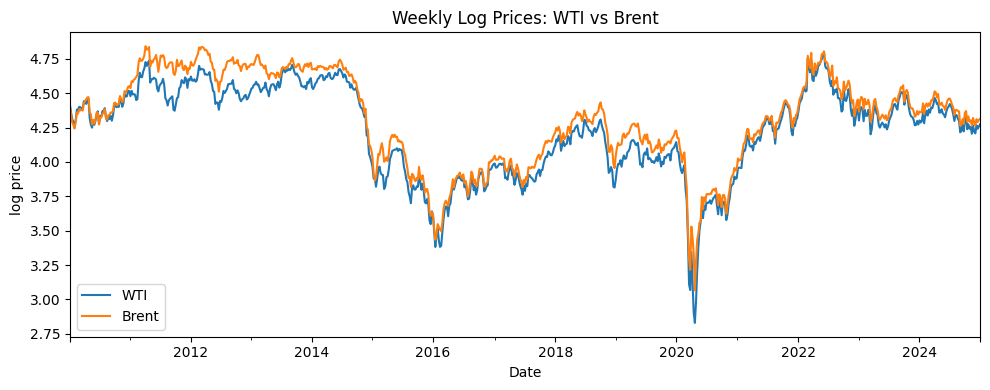

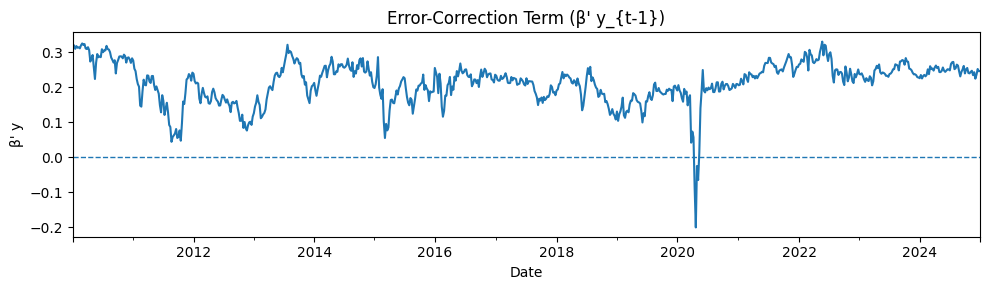

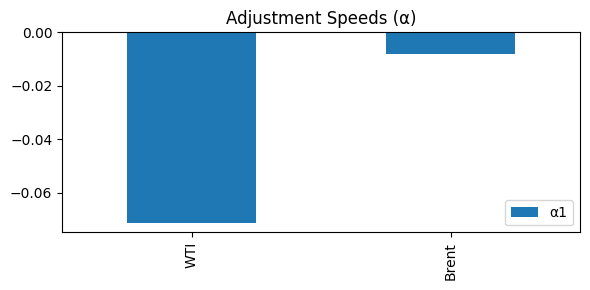

<Figure size 1000x300 with 0 Axes>

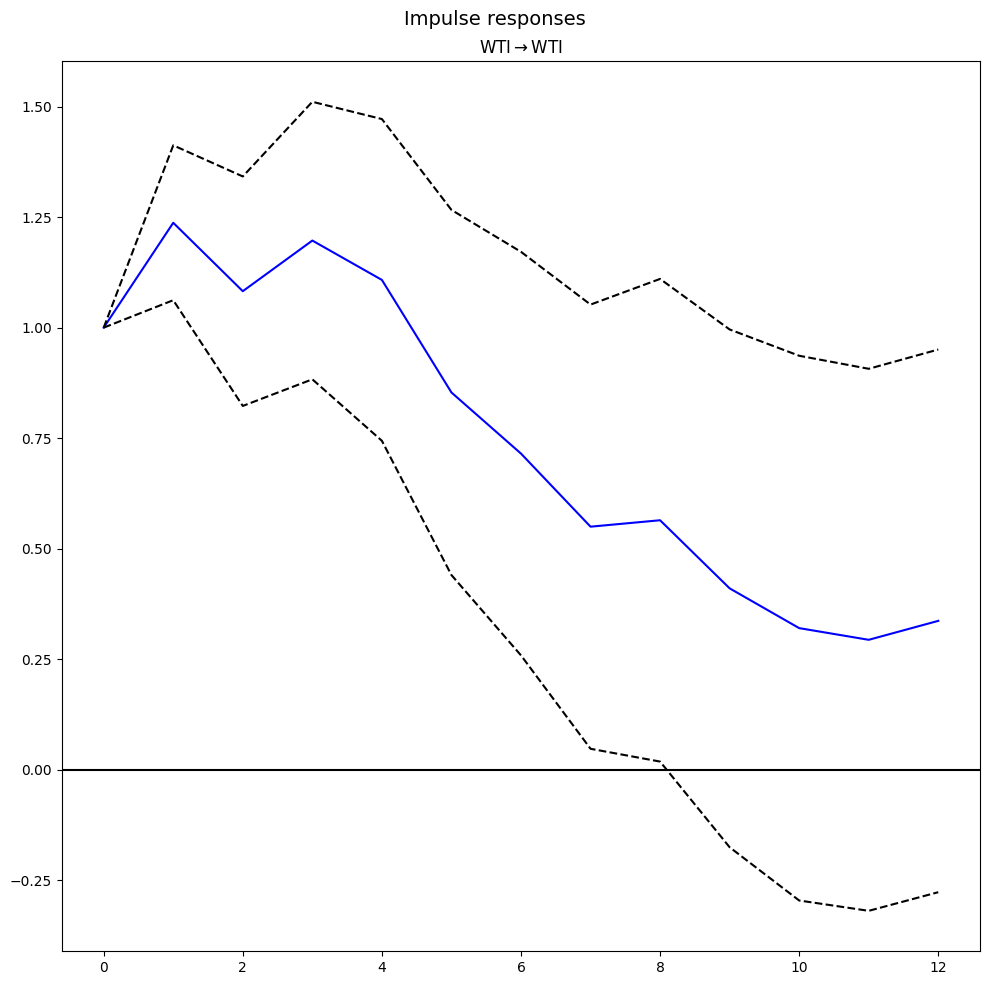

<Figure size 1000x300 with 0 Axes>

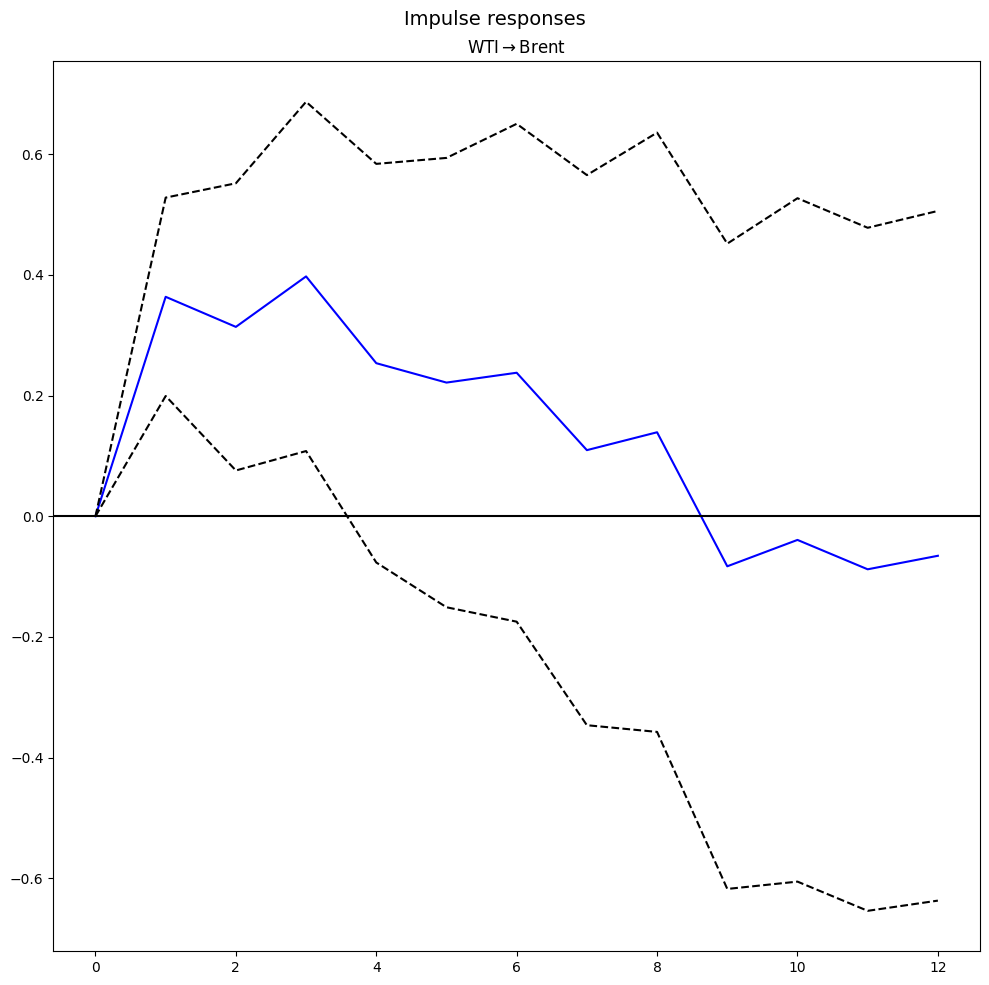

<Figure size 1000x300 with 0 Axes>

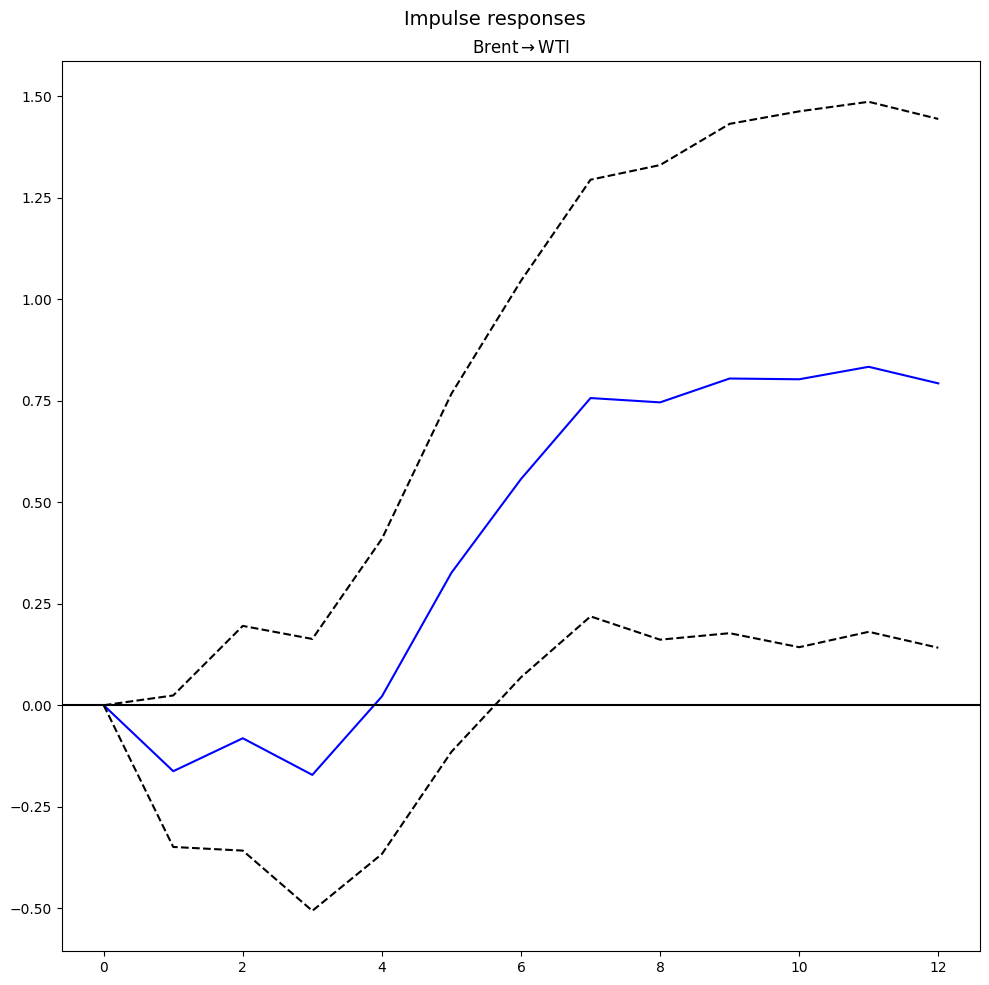

<Figure size 1000x300 with 0 Axes>

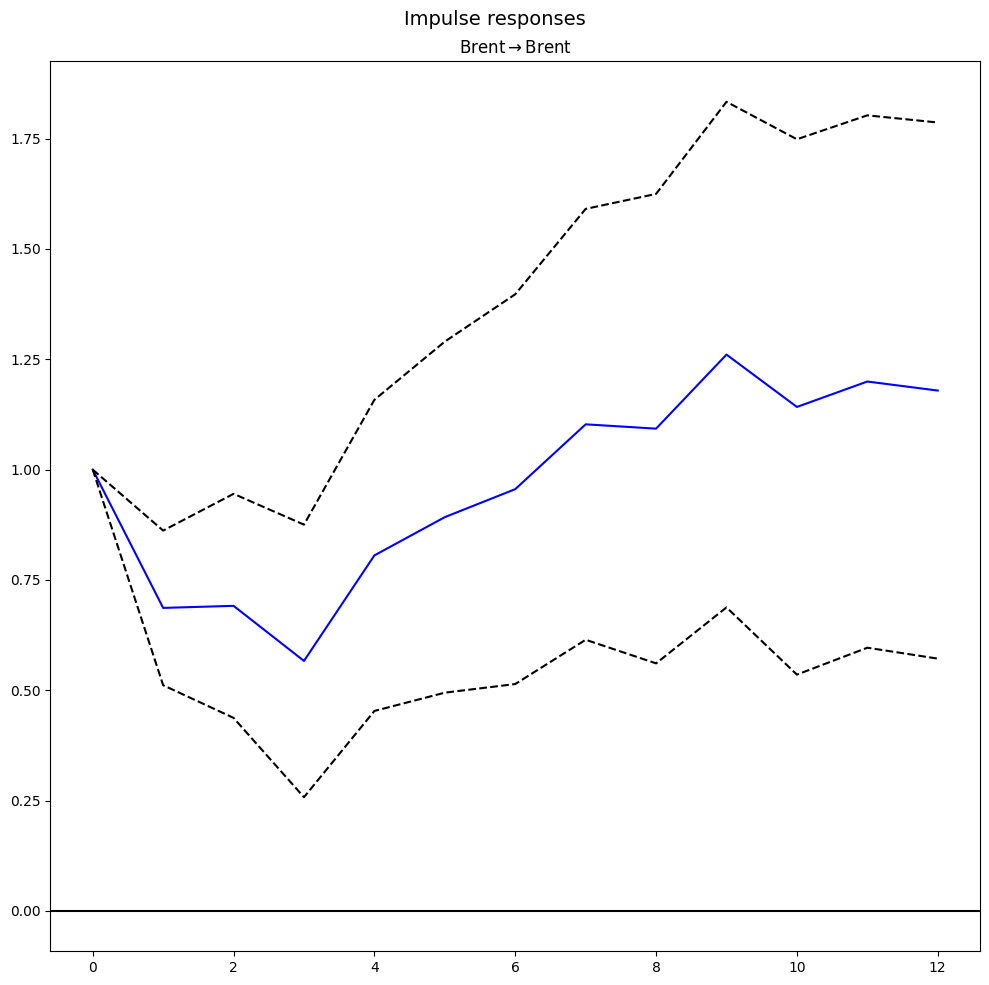

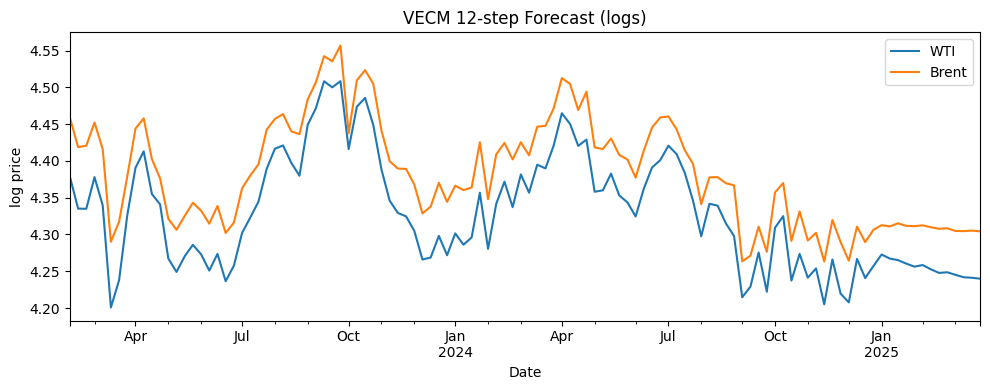

In [17]:
import warnings
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM
from numpy.linalg import LinAlgError
from statsmodels.tsa.stattools import adfuller, coint

plt.rcParams["figure.figsize"] = (10, 4)

# -----------------------------
# 0) Settings
# -----------------------------
Y_TICK, X_TICK = "CL=F", "BZ=F"     # WTI, Brent
START, END     = "2010-01-01", "2025-01-01"
DET_ORDER      = 0    # 0: intercept in cointegration space (common in practice)

# -----------------------------
# 1) Download, align, weekly
# -----------------------------
raw = yf.download([Y_TICK, X_TICK], start=START, end=END, auto_adjust=True,
                  progress=False, group_by="ticker", threads=True)

def pick_close(frame, ticker):
    if isinstance(frame.columns, pd.MultiIndex):
        if "Close" in frame.columns.get_level_values(0):
            s = frame["Close"][ticker]
        elif "Close" in frame.columns.get_level_values(-1):
            s = frame.xs("Close", axis=1, level=-1)[ticker]
        else:
            raise KeyError("Close not found")
    else:
        s = frame["Close"] if "Close" in frame.columns else frame["Adj Close"]
    return s.dropna().rename(ticker)

WTI = pick_close(raw, Y_TICK)
BRENT = pick_close(raw, X_TICK)

daily = pd.concat([WTI, BRENT], axis=1).sort_index().ffill().dropna()
weekly = daily.resample("W-FRI").last().dropna()
weekly.columns = ["WTI", "Brent"]

# Work in logs (common in commodity/FX)
logp = np.log(weekly)
y = logp[["WTI","Brent"]]

# -----------------------------
# 2) Quick prechecks (optional)
# -----------------------------
def adf(name, s):
    stat, p, _, _, *_ = adfuller(s.dropna(), autolag="AIC")
    print(f"ADF {name}: p={p:.4g}")

print("\nUnit-root sanity (levels should be non-stationary, diffs stationary):")
adf("log WTI", y["WTI"])
adf("log Brent", y["Brent"])
adf("Δlog WTI", y["WTI"].diff().dropna())
adf("Δlog Brent", y["Brent"].diff().dropna())

# -----------------------------
# 3) Select lag for VECM from VAR on differences
#    (k_ar_diff is number of lags in Δy_t)
# -----------------------------
dlog = y.diff().dropna()
kmax = min(12, max(2, int(len(dlog)/20)))
sel = VAR(dlog).select_order(maxlags=kmax)
k_ar = sel.selected_orders.get("aic") or sel.selected_orders.get("bic") or 1
k_ar = int(max(1, min(k_ar, kmax)))
print(f"\nSelected k_ar_diff (lags in Δy): {k_ar}")

# -----------------------------
# 4) Johansen to determine rank r and β (cointegration vector)
# -----------------------------
try:
    jres = coint_johansen(y, det_order=DET_ORDER, k_ar_diff=k_ar)
    # Decide rank: check trace stats against 5% critvals
    trace, cv5 = jres.lr1, jres.cvt[:,1]
    r = int((trace > cv5).sum())  # number of rejections
    r = max(1, min(r, 1))         # force r=1 for this example
    print(f"Johansen trace: {trace}, 5% crit: {cv5}, chosen rank r={r}")
except (LinAlgError, ValueError) as e:
    # Fallback: if Johansen fails, assume r=1 (WTI~Brent is very tight)
    print(f"Johansen failed ({e}); proceeding with rank r=1")
    r = 1

# -----------------------------
# 5) Fit VECM
# -----------------------------
vecm = VECM(y, k_ar_diff=k_ar, coint_rank=r, deterministic="ci" if DET_ORDER==0 else "lt")
res = vecm.fit()

# Cointegration vector(s) β (normalized by statsmodels)
beta = res.beta  # shape (m, r)
alpha = res.alpha  # adjustment speeds (m, r)

print("\nCointegration β (columns):")
print(pd.DataFrame(beta, index=y.columns, columns=[f"β{j+1}" for j in range(beta.shape[1])]))
print("\nAdjustment α:")
print(pd.DataFrame(alpha, index=y.columns, columns=[f"α{j+1}" for j in range(alpha.shape[1])]))

# Construct the error-correction term e_{t-1} = β' y_{t-1} (for visualization)
ec_term = (y.shift(1).to_numpy() @ beta).squeeze()
ec_term = pd.Series(ec_term, index=y.index, name="EC term")

# -----------------------------
# 6) Plots: levels, EC term, α loadings
# -----------------------------
# Levels
plt.figure(figsize=(10,4))
y.plot(ax=plt.gca(), title="Weekly Log Prices: WTI vs Brent")
plt.xlabel("Date"); plt.ylabel("log price")
plt.tight_layout(); plt.show()

# Error-correction term (should look stationary)
plt.figure(figsize=(10,3))
ec_term.plot(ax=plt.gca(), title="Error-Correction Term (β' y_{t-1})")
plt.axhline(0, linestyle="--", linewidth=1)
plt.xlabel("Date"); plt.ylabel("β' y")
plt.tight_layout(); plt.show()

# α loadings (who adjusts)
plt.figure(figsize=(6,3))
(pd.DataFrame(alpha, index=y.columns, columns=[f"α{j+1}" for j in range(alpha.shape[1])])
 .plot(kind="bar", ax=plt.gca(), title="Adjustment Speeds (α)"))
plt.tight_layout(); plt.show()

# -----------------------------
# 7) Impulse Responses (IRFs) from VECM
# -----------------------------
# statsmodels provides IRFs directly
irf = res.irf(12)  # 12-step horizon
# Plot each response separately (one per figure)
plt.figure(figsize=(10,3))
irf.plot(orth=False, impulse=0, response=0)  # shock to WTI, response of WTI
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,3))
irf.plot(orth=False, impulse=0, response=1)  # shock to WTI, response of Brent
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,3))
irf.plot(orth=False, impulse=1, response=0)  # shock to Brent, response of WTI
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,3))
irf.plot(orth=False, impulse=1, response=1)  # shock to Brent, response of Brent
plt.tight_layout(); plt.show()

# -----------------------------
# 8) Forecast (multi-step) from last observed point
# -----------------------------
steps = 12
fc = res.predict(steps=steps)  # returns levels (log prices) in VECM's representation
fc_idx = pd.date_range(y.index[-1] + pd.offsets.Week(weekday=4), periods=steps, freq="W-FRI")
fc_df = pd.DataFrame(fc, index=fc_idx, columns=y.columns)

plt.figure(figsize=(10,4))
pd.concat([y.tail(100), fc_df]).plot(ax=plt.gca(), title="VECM 12-step Forecast (logs)")
plt.xlabel("Date"); plt.ylabel("log price")
plt.tight_layout(); plt.show()


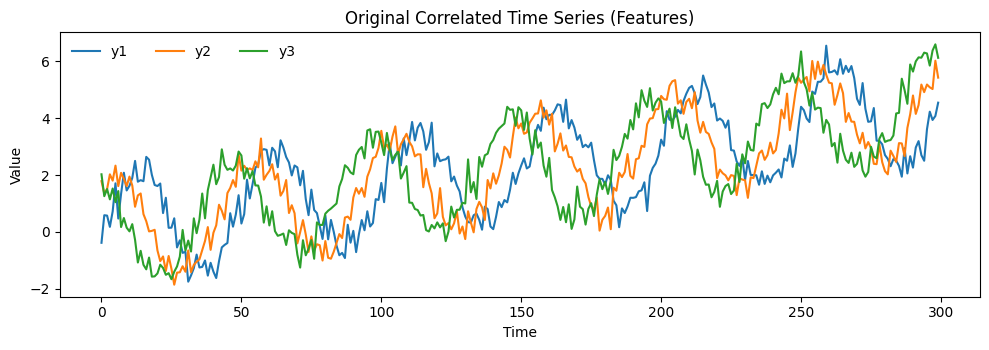

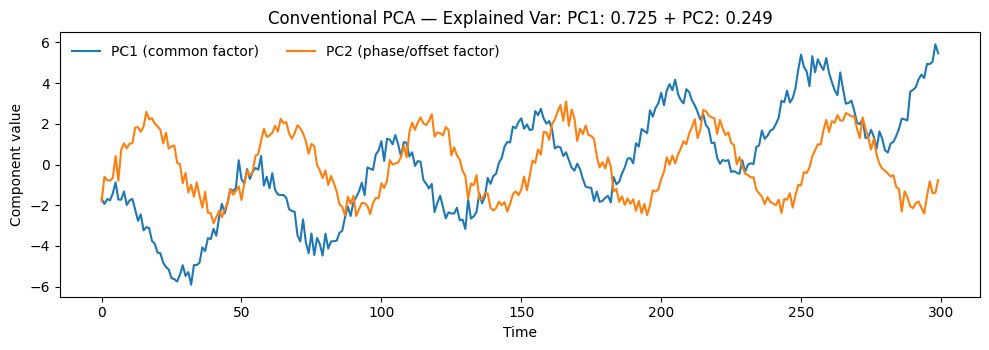

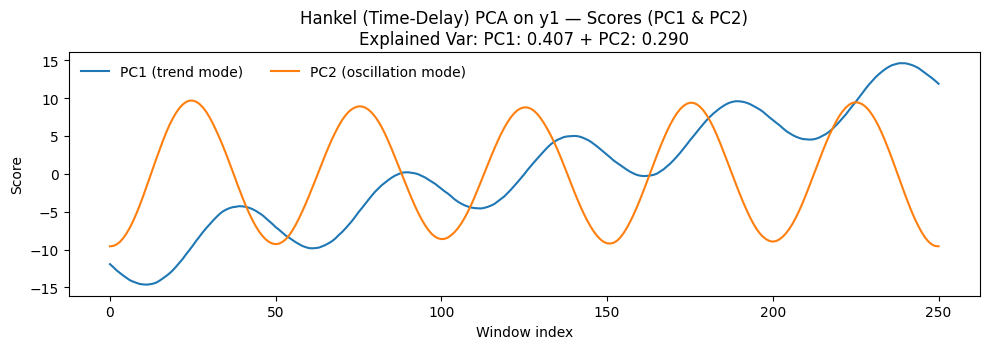

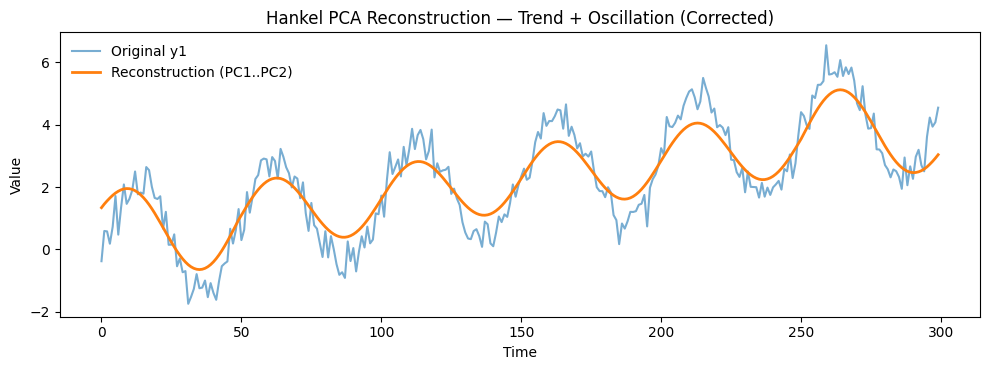

Conventional PCA (features y1,y2,y3) explained variance: [0.725 0.249]
Hankel PCA (time-delay on y1) explained variance: [0.407 0.29  0.264 0.002 0.002]
corr(original y1, reconstructed) = 0.952


In [27]:
# Conventional PCA vs Hankel (Time-Delay) PCA — One Complete Script
# ----------------------------------------------------------------
# What it does:
# 1) Simulates three correlated time series (shared trend + seasonal oscillation + noise).
# 2) Plots the original features.
# 3) Runs Conventional PCA across the three series and plots PC1/PC2 over time.
# 4) Runs Hankel (time-delay) PCA on a single series; plots PC1 (trend) & PC2 (oscillation).
# 5) Reconstructs the single series from Hankel PCs (PC1+PC2) with CORRECT mean add-back
#    and sign/orientation alignment; plots original vs reconstruction.
#
# Dependencies: numpy, pandas, matplotlib, scikit-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# -----------------------------
# Helpers (Hankel + SSA averaging)
# -----------------------------
def hankel_matrix(series: np.ndarray, window: int = 50) -> np.ndarray:
    """
    Build a Hankel (time-delay) matrix for 1D series.
    Rows are sliding windows of length 'window'.
    Shape: (T - window + 1, window)
    """
    n = len(series)
    if window >= n:
        raise ValueError("window must be smaller than series length")
    return np.column_stack([series[i:n - window + i + 1] for i in range(window)])

def diagonal_averaging(H: np.ndarray) -> np.ndarray:
    """
    SSA-style diagonal averaging to map Hankel matrix back to a 1D series.
    H shape: (N, W) where N = T - W + 1. Returns length T = N + W - 1.
    """
    N, W = H.shape
    T = N + W - 1
    y = np.zeros(T, dtype=float)
    c = np.zeros(T, dtype=float)
    for i in range(N):
        for j in range(W):
            y[i + j] += H[i, j]
            c[i + j] += 1.0
    return y / c

def explained_var_table(pca_obj: PCA, k: int = 2) -> str:
    r = pca_obj.explained_variance_ratio_[:k]
    return " + ".join([f"PC{i+1}: {r[i]:.3f}" for i in range(len(r))])

# -----------------------------
# 1) Simulate correlated series
# -----------------------------
np.random.seed(123)
T = 300
t = np.arange(T)
trend   = 0.015 * t
season  = 1.8 * np.sin(2 * np.pi * t / 50)      # oscillation period ≈ 50
noise   = 0.35 * np.random.randn(T)

y1 = trend + season + noise
y2 = trend + 1.8 * np.sin(2 * np.pi * (t +  8) / 50) + 0.35 * np.random.randn(T)  # phase-shifted
y3 = trend + 1.8 * np.sin(2 * np.pi * (t + 16) / 50) + 0.35 * np.random.randn(T)  # more shift
X_feat = np.column_stack([y1, y2, y3])  # (T, 3)

# -----------------------------
# 2) Plot original features
# -----------------------------
plt.figure(figsize=(10, 3.6))
plt.plot(t, y1, label="y1")
plt.plot(t, y2, label="y2")
plt.plot(t, y3, label="y3")
plt.title("Original Correlated Time Series (Features)")
plt.xlabel("Time"); plt.ylabel("Value")
plt.legend(ncol=3, frameon=False)
plt.tight_layout()
plt.show()

# -----------------------------
# 3) Conventional PCA (across features)
# -----------------------------
pca_conv = PCA(n_components=2)
pcs_conv = pca_conv.fit_transform(X_feat)  # (T, 2)

plt.figure(figsize=(10, 3.6))
plt.plot(t, pcs_conv[:, 0], label="PC1 (common factor)")
plt.plot(t, pcs_conv[:, 1], label="PC2 (phase/offset factor)")
plt.title(f"Conventional PCA — Explained Var: {explained_var_table(pca_conv)}")
plt.xlabel("Time"); plt.ylabel("Component value")
plt.legend(ncol=2, frameon=False)
plt.tight_layout()
plt.show()

# -----------------------------
# 4) Hankel (time-delay) PCA on y1
# -----------------------------
WINDOW = 50
X_hankel = hankel_matrix(y1, window=WINDOW)   # (T - WINDOW + 1, WINDOW)

# Fit with more comps; visualize first 2 (trend + oscillation)
pca_hank = PCA(n_components=10)
scores_h = pca_hank.fit_transform(X_hankel)   # = (X - mean) @ components.T

# Plot PC1/PC2 time series (over window index)
plt.figure(figsize=(10, 3.6))
plt.plot(scores_h[:, 0], label="PC1 (trend mode)")
plt.plot(scores_h[:, 1], label="PC2 (oscillation mode)")
plt.title(f"Hankel (Time-Delay) PCA on y1 — Scores (PC1 & PC2)\nExplained Var: {explained_var_table(pca_hank)}")
plt.xlabel("Window index"); plt.ylabel("Score")
plt.legend(ncol=2, frameon=False)
plt.tight_layout()
plt.show()

# -----------------------------
# 5) Reconstruction from Hankel PCs (PC1+PC2) — with mean & sign fix
# -----------------------------
k_use = 2
# Recompose centered Hankel matrix and ADD BACK MEAN (critical)
X_recon_centered = scores_h[:, :k_use] @ pca_hank.components_[:k_use, :]   # (N, W)
X_recon = X_recon_centered + pca_hank.mean_[None, :]                        # add back PCA mean
y1_rec = diagonal_averaging(X_recon)                                        # length T

# Orientation fix: eigenvector signs are arbitrary — align to original
if np.corrcoef(y1, y1_rec[:T])[0, 1] < 0:
    y1_rec = -(y1_rec - y1_rec.mean()) + y1.mean()

# Plot original vs reconstruction
plt.figure(figsize=(10, 3.8))
plt.plot(y1, label="Original y1", alpha=0.6)
plt.plot(y1_rec[:T], label=f"Reconstruction (PC1..PC{k_use})", linewidth=2)
plt.title("Hankel PCA Reconstruction — Trend + Oscillation (Corrected)")
plt.xlabel("Time"); plt.ylabel("Value")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# -----------------------------
# 6) Text summary
# -----------------------------
print("Conventional PCA (features y1,y2,y3) explained variance:",
      np.round(pca_conv.explained_variance_ratio_, 3))
print("Hankel PCA (time-delay on y1) explained variance:",
      np.round(pca_hank.explained_variance_ratio_[:5], 3))
print("corr(original y1, reconstructed) =",
      round(float(np.corrcoef(y1, y1_rec[:T])[0, 1]), 3))


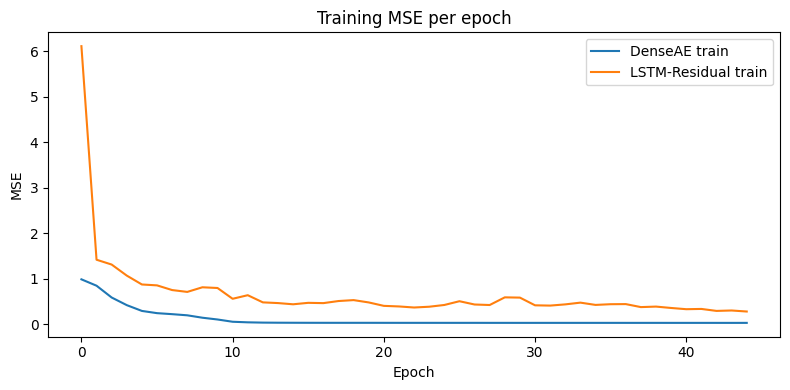

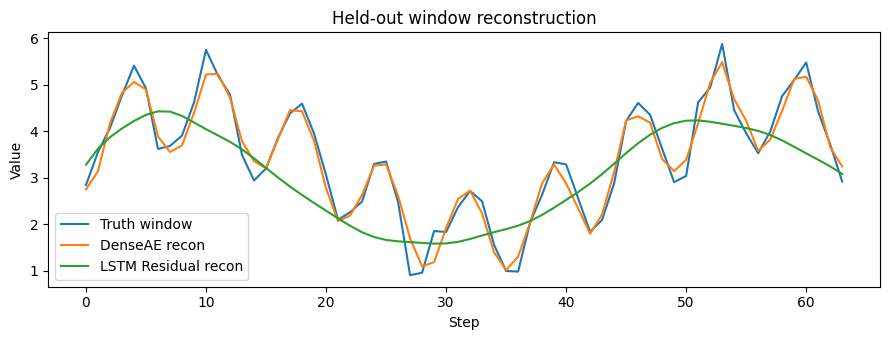

Dense-normal    0.03090
Dense-shuffle   0.63510
Dense-reverse   0.03217
Dense-cshift    0.17433
LSTM-normal     0.30503
LSTM-shuffle    1.20914
LSTM-reverse    0.29999
LSTM-cshift     0.62807


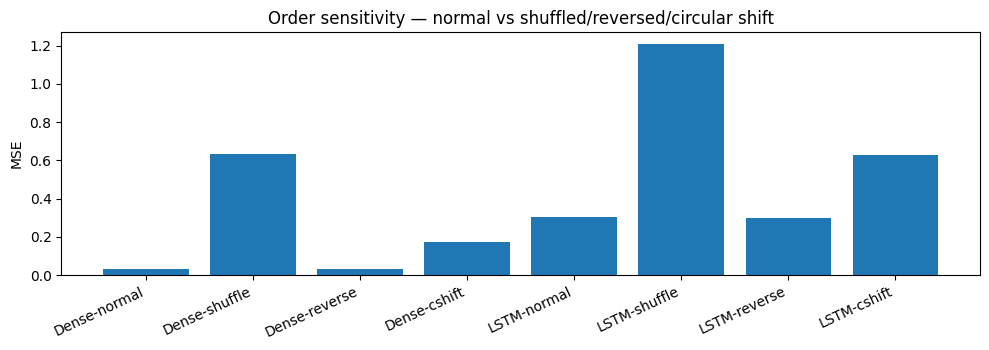

In [30]:
# Dense vs Order-Aware LSTM Autoencoder for Time Series
# - Dense AE (position-anchored baseline)
# - Improved LSTM Seq2Seq AE (residual decoding + positional encodings + scheduled teacher forcing)
# Includes: reconstruction plots and order-perturbation tests (shuffle/reverse/circular shift)

import numpy as np
import torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# -----------------------
# 0) Reproducibility
# -----------------------
np.random.seed(7)
torch.manual_seed(7)

# -----------------------
# 1) Simulate series
# -----------------------
T = 3000
t = np.arange(T)
trend  = 0.0012 * t
season = 1.4 * np.sin(2 * np.pi * t / 48) + 0.9 * np.sin(2 * np.pi * t / 7)
noise  = 0.25 * np.random.randn(T)
y      = trend + season + noise

# -----------------------
# 2) Windowing
# -----------------------
WIN, STRIDE = 64, 2
def make_windows(series, win=WIN, stride=STRIDE):
    out = []
    for i in range(0, len(series) - win + 1, stride):
        out.append(series[i:i+win])
    return np.stack(out)

X_all = make_windows(y, WIN, STRIDE)
N = len(X_all)
split = int(0.8 * N)
X_train, X_test = X_all[:split], X_all[split:]

# Standardize by train stats
mu, sd = X_train.mean(), X_train.std() + 1e-8
X_train = (X_train - mu) / sd
X_test  = (X_test  - mu) / sd

Xtr_vec = torch.tensor(X_train, dtype=torch.float32)            # (n, win)
Xte_vec = torch.tensor(X_test,  dtype=torch.float32)
Xtr_seq = Xtr_vec.unsqueeze(-1)                                 # (n, win, 1)
Xte_seq = Xte_vec.unsqueeze(-1)

BATCH = 128
tr_loader_vec = DataLoader(TensorDataset(Xtr_vec), batch_size=BATCH, shuffle=True)
tr_loader_seq = DataLoader(TensorDataset(Xtr_seq), batch_size=BATCH, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------
# 3) Models
# -----------------------
LATENT = 16

class DenseAE(nn.Module):
    def __init__(self, win=WIN, latent=LATENT):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(win, 128), nn.ReLU(),
            nn.Linear(128, 64),  nn.ReLU(),
            nn.Linear(64, latent)
        )
        self.dec = nn.Sequential(
            nn.Linear(latent, 64),  nn.ReLU(),
            nn.Linear(64, 128),     nn.ReLU(),
            nn.Linear(128, win)
        )
    def forward(self, x):                    # (B, win)
        z = self.enc(x)
        xhat = self.dec(z)
        return xhat, z

def pos_encoding(win=WIN, d=8, device="cpu"):
    """Fixed sin/cos positional encodings for steps 0..win-1 (shape: win x (2d))."""
    idx = torch.arange(win, device=device).float().unsqueeze(1)      # (win,1)
    k   = torch.arange(d,   device=device).float().unsqueeze(0)      # (1,d)
    div = torch.pow(10000.0, (2*k)/max(1,(2*d)))                     # (1,d)
    sin = torch.sin(idx / div)                                       # (win,d)
    cos = torch.cos(idx / div)                                       # (win,d)
    return torch.cat([sin, cos], dim=1)                              # (win,2d)

class LSTMSeq2SeqResidual(nn.Module):
    """
    Encoder: 2-layer LSTM reads sequence in order.
    Decoder: 2-layer LSTM predicts residuals Δx_t with positional encodings at each step.
             Scheduled teacher forcing is applied externally.
    """
    def __init__(self, in_dim=1, hidden=96, latent=LATENT, win=WIN, pe_dim=8):
        super().__init__()
        self.enc = nn.LSTM(in_dim, hidden, num_layers=2, batch_first=True)
        self.h_to_z = nn.Linear(hidden, latent)
        self.z_to_h = nn.Linear(latent, hidden)

        self.pe = pos_encoding(win, d=pe_dim, device=device)          # (win, 2*pe_dim)
        self.dec_in_dim = 1 + 2*pe_dim                                # prev_val + PE
        self.dec = nn.LSTM(self.dec_in_dim, hidden, num_layers=2, batch_first=True)
        self.out = nn.Linear(hidden, 1)                                # predict Δx_t
        self.win = win

    def forward(self, x, teacher_forcing_ratio=0.0):
        B = x.size(0)
        # -------- Encoder --------
        enc_out, (h, c) = self.enc(x)                  # h: (2,B,H)
        h_last = h[-1]                                 # (B,H)
        z = self.h_to_z(h_last)
        h0 = torch.tanh(self.z_to_h(z)).unsqueeze(0).repeat(2,1,1)    # (2,B,H)
        c0 = torch.zeros_like(h0)

        # -------- Decoder (residuals) --------
        y_prev = x[:, :1, :]                           # start token = first true value
        outs = []
        for t in range(self.win):
            # concat prev value with positional encoding at step t
            pe_t = self.pe[t:t+1, :].unsqueeze(0).repeat(B,1,1)       # (B,1,2d)
            dec_in = torch.cat([y_prev, pe_t], dim=-1)                # (B,1,1+2d)
            dec_out, (h0, c0) = self.dec(dec_in, (h0, c0))
            delta = self.out(dec_out)                                 # (B,1,1)
            if t == 0:
                y_curr = y_prev + delta                               # x_0 + Δx_0
            else:
                y_curr = outs[-1] + delta                             # cumulative residuals
            outs.append(y_curr)                                       # store absolute level

            # teacher forcing (use true next value) vs self-generated
            use_teacher = (np.random.rand() < teacher_forcing_ratio)
            y_prev = (x[:, t:t+1, :] if use_teacher else y_curr)

        y_hat = torch.cat(outs, dim=1)                                # (B,win,1)
        return y_hat.squeeze(-1), z

denseae = DenseAE().to(device)
lstmAE  = LSTMSeq2SeqResidual().to(device)

# -----------------------
# 4) Train (scheduled teacher forcing)
# -----------------------
EPOCHS = 45
crit = nn.MSELoss()
optD = torch.optim.Adam(denseae.parameters(), lr=1e-3)
optL = torch.optim.Adam(lstmAE.parameters(),  lr=2e-3)

dense_tr, lstm_tr = [], []

for ep in range(1, EPOCHS+1):
    tf = max(0.0, 0.9 - 0.9*(ep-1)/(EPOCHS-1))   # 0.9 -> 0.0 linearly
    # ----- Dense -----
    denseae.train(); loss_sum=0.0; n=0
    for (xb,) in tr_loader_vec:
        xb = xb.to(device)
        xhat, _ = denseae(xb)
        loss = crit(xhat, xb)
        optD.zero_grad(); loss.backward(); nn.utils.clip_grad_norm_(denseae.parameters(), 1.0); optD.step()
        loss_sum += float(loss) * len(xb); n += len(xb)
    dense_tr.append(loss_sum/n)

    # ----- LSTM -----
    lstmAE.train(); loss_sum=0.0; n=0
    for (xb,) in tr_loader_seq:
        xb = xb.to(device)
        xhat, _ = lstmAE(xb, teacher_forcing_ratio=tf)
        loss = crit(xhat, xb.squeeze(-1))
        optL.zero_grad(); loss.backward(); nn.utils.clip_grad_norm_(lstmAE.parameters(), 1.0); optL.step()
        loss_sum += float(loss) * len(xb); n += len(xb)
    lstm_tr.append(loss_sum/n)

# -----------------------
# 5) Loss curves
# -----------------------
plt.figure(figsize=(8,4))
plt.plot(dense_tr, label="DenseAE train")
plt.plot(lstm_tr,  label="LSTM-Residual train")
plt.title("Training MSE per epoch")
plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.legend(); plt.tight_layout(); plt.show()

# -----------------------
# 6) Reconstructions on held-out window
# -----------------------
denseae.eval(); lstmAE.eval()
with torch.no_grad():
    idx = len(Xte_vec)//2
    x_vec = Xte_vec[idx:idx+1].to(device)
    x_seq = Xte_seq[idx:idx+1].to(device)
    xhatD,_ = denseae(x_vec)
    xhatL,_ = lstmAE(x_seq, teacher_forcing_ratio=0.0)

x_true = x_vec.squeeze(0).cpu().numpy()
xhD    = xhatD.squeeze(0).cpu().numpy()
xhL    = xhatL.squeeze(0).cpu().numpy()

# de-normalize
x_true_dn = x_true * sd + mu
xhD_dn    = xhD   * sd + mu
xhL_dn    = xhL   * sd + mu

plt.figure(figsize=(9,3.5))
plt.plot(x_true_dn, label="Truth window")
plt.plot(xhD_dn,   label="DenseAE recon")
plt.plot(xhL_dn,   label="LSTM Residual recon")
plt.title("Held-out window reconstruction")
plt.xlabel("Step"); plt.ylabel("Value"); plt.legend(); plt.tight_layout(); plt.show()

# -----------------------
# 7) Order-perturbation tests
# -----------------------
def shuffle_inside(X):
    Xs = X.copy()
    for i in range(len(Xs)):
        perm = np.random.permutation(WIN)
        Xs[i] = Xs[i][perm]
    return Xs

def reverse_windows(X):
    return np.flip(X, axis=1).copy()

def circular_shift(X, k=8):
    return np.roll(X, shift=k, axis=1)

def mse_dense(model, X):
    with torch.no_grad():
        xb = torch.tensor(X, dtype=torch.float32, device=device)
        xhat,_ = model(xb); return float(nn.functional.mse_loss(xhat, xb))

def mse_lstm(model, X):
    with torch.no_grad():
        xb = torch.tensor(X[...,None], dtype=torch.float32, device=device)
        xhat,_ = model(xb, teacher_forcing_ratio=0.0)
        return float(nn.functional.mse_loss(xhat, xb.squeeze(-1)))

Xn = X_test.copy()
Xs = shuffle_inside(X_test.copy())
Xr = reverse_windows(X_test.copy())
Xc = circular_shift(X_test.copy(), k=8)

results = {
    "Dense-normal":  mse_dense(denseae, Xn),
    "Dense-shuffle": mse_dense(denseae, Xs),
    "Dense-reverse": mse_dense(denseae, Xr),
    "Dense-cshift":  mse_dense(denseae, Xc),
    "LSTM-normal":   mse_lstm(lstmAE,  Xn),
    "LSTM-shuffle":  mse_lstm(lstmAE,  Xs),
    "LSTM-reverse":  mse_lstm(lstmAE,  Xr),
    "LSTM-cshift":   mse_lstm(lstmAE,  Xc),
}
for k,v in results.items():
    print(f"{k:15s} {v:.5f}")

plt.figure(figsize=(10,3.6))
labels = list(results.keys()); vals = [results[k] for k in labels]
plt.bar(np.arange(len(vals)), vals)
plt.xticks(np.arange(len(vals)), labels, rotation=25, ha="right")
plt.title("Order sensitivity — normal vs shuffled/reversed/circular shift")
plt.ylabel("MSE"); plt.tight_layout(); plt.show()


OVERALL  RF : {'MAE': 0.3243921115723544, 'RMSE': 0.4135121043934853} 
OVERALL  XGB: {'MAE': 0.26615148718689935, 'RMSE': 0.32374083925874125}
REGIME A RF : {'MAE': 0.11836386802446464, 'RMSE': 0.11836386802446464} 
REGIME A XGB: {'MAE': 0.20830156402918287, 'RMSE': 0.20830156402918287}
REGIME B RF : {'MAE': 0.326473204941525, 'RMSE': 0.41542501107377733} 
REGIME B XGB: {'MAE': 0.26673582984505817, 'RMSE': 0.3246975836007185}


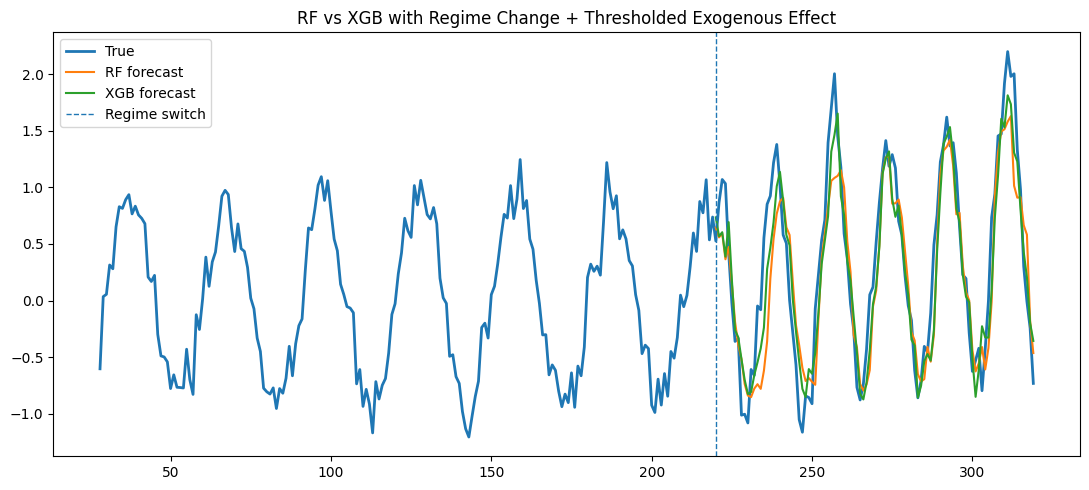

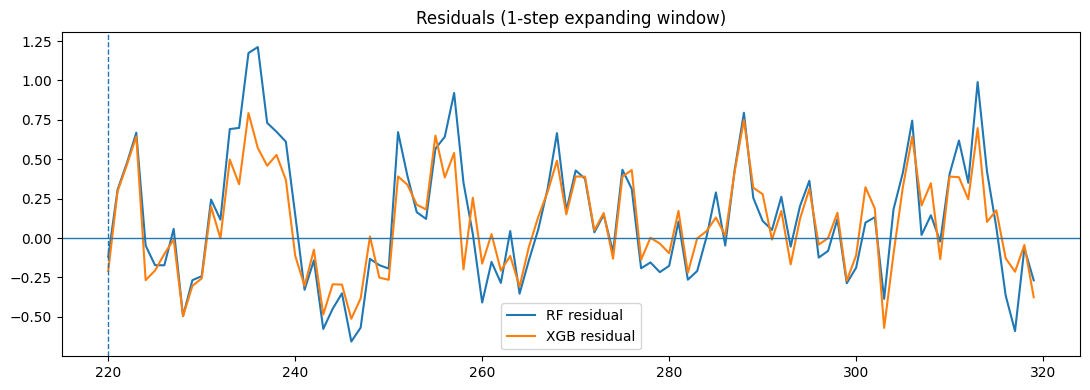

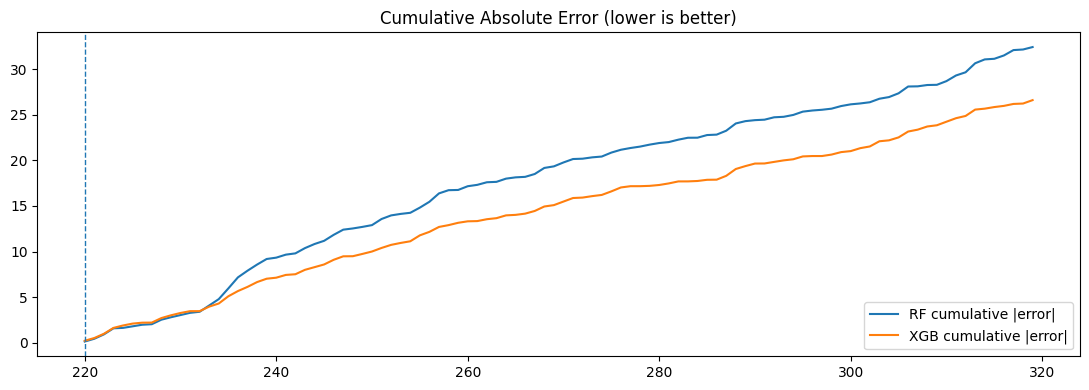

In [2]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

rng = np.random.default_rng(42)

# --------------------------
# 1) Data-generating process
# --------------------------
n = 320
t = np.arange(n)
# exogenous driver (e.g., "promo intensity" or "temperature")
z = 0.4*np.sin(2*np.pi*t/14) + 0.6*np.sin(2*np.pi*t/50) + rng.normal(0, 0.2, n)
thr = 0.4  # threshold at which the driver meaningfully affects y

# base regime A
y = 0.9*np.sin(2*np.pi*t/30) + 0.15*rng.normal(0,1,n)

# regime B: frequency change + trend + nonlinear driver kicks in
maskB = (t > 220)
y[maskB] = (
    1.1*np.sin(2*np.pi*t[maskB]/18)      # faster seasonality
    + 0.006*(t[maskB]-220)               # emergent linear trend
    + 0.15*rng.normal(0,1,maskB.sum())
)

# Nonlinear/thresholded exogenous effect (acts stronger in Regime B)
zlag = np.roll(z, 1); zlag[0] = zlag[1]
driver_effect = np.where((zlag > thr) & maskB, 0.7*(zlag - thr), 0.0)
y = y + driver_effect

df = pd.DataFrame({"t": t, "y": y, "z": z})

# --------------------------
# 2) Feature engineering
# --------------------------
def add_time_features(df, max_lag=14, roll_windows=(7, 28), period=30):
    out = df.copy()
    for L in range(1, max_lag+1):
        out[f"lag_{L}"] = out["y"].shift(L)
    for w in roll_windows:
        out[f"roll_mean_{w}"] = out["y"].shift(1).rolling(w).mean()
        out[f"roll_std_{w}"]  = out["y"].shift(1).rolling(w).std()
        out[f"z_roll_{w}"]    = out["z"].shift(1).rolling(w).mean()
    # Fourier seasonality on time index
    out["sin1"] = np.sin(2*np.pi*out["t"]/period)
    out["cos1"] = np.cos(2*np.pi*out["t"]/period)
    out["trend"] = out["t"]  # give models a trend channel
    # exogenous raw + lag
    out["z_lag1"] = out["z"].shift(1)
    out["z_lag7"] = out["z"].shift(7)
    return out

X = add_time_features(df)
X = X.dropna().reset_index(drop=True)

# Where to start forecasting (after all lags/rolls exist)
start_forecast_idx = 220   # we want to cross the regime break
horizon_steps = X.index[X["t"] >= start_forecast_idx][0]

# --------------------------
# 3) Expanding walk-forward
# --------------------------
features = [c for c in X.columns if c not in ["y","t"]]
y_true, y_rf, y_xgb, tt = [], [], [], []

rf_params = dict(n_estimators=400, max_depth=None, min_samples_leaf=5, random_state=42, n_jobs=-1)
xgb_params = dict(
    n_estimators=600, learning_rate=0.05, max_depth=5,
    subsample=0.8, colsample_bytree=0.9, reg_lambda=2.0,
    random_state=42, objective="reg:squarederror"
)

for i in range(horizon_steps, len(X)):
    train = X.iloc[:i]
    test_row = X.iloc[i:i+1]
    Xtr, ytr = train[features], train["y"]
    Xte = test_row[features]
    
    rf = RandomForestRegressor(**rf_params)
    rf.fit(Xtr, ytr)
    pred_rf = rf.predict(Xte)[0]
    
    xgb = XGBRegressor(**xgb_params)
    xgb.fit(Xtr, ytr, verbose=False)
    pred_xgb = xgb.predict(Xte)[0]
    
    y_true.append(test_row["y"].item())
    y_rf.append(pred_rf)
    y_xgb.append(pred_xgb)
    tt.append(test_row["t"].item())

y_true = np.array(y_true); y_rf = np.array(y_rf); y_xgb = np.array(y_xgb); tt = np.array(tt)

# --------------------------
# 4) Metrics: overall & by regime
# --------------------------
def metrics(y, yhat):
    mae = mean_absolute_error(y, yhat)
    mse = mean_squared_error(y, yhat)   # MSE only
    rmse = float(np.sqrt(mse))          # compute RMSE manually
    return {"MAE": float(mae), "RMSE": rmse}

overall_rf  = metrics(y_true, y_rf)
overall_xgb = metrics(y_true, y_xgb)

mask_regA = tt <= 220
mask_regB = tt > 220

regA_rf,  regA_xgb  = metrics(y_true[mask_regA], y_rf[mask_regA]),  metrics(y_true[mask_regA], y_xgb[mask_regA])
regB_rf,  regB_xgb  = metrics(y_true[mask_regB], y_rf[mask_regB]),  metrics(y_true[mask_regB], y_xgb[mask_regB])

print("OVERALL  RF :", overall_rf, "\nOVERALL  XGB:", overall_xgb)
print("REGIME A RF :", regA_rf,   "\nREGIME A XGB:", regA_xgb)
print("REGIME B RF :", regB_rf,   "\nREGIME B XGB:", regB_xgb)

# --------------------------
# 5) Plots for slides
# --------------------------

# (A) Forecast overlay
plt.figure(figsize=(11,5))
plt.plot(X["t"], X["y"], label="True", linewidth=2)
plt.plot(tt, y_rf, label="RF forecast")
plt.plot(tt, y_xgb, label="XGB forecast")
plt.axvline(220, linestyle="--", linewidth=1, label="Regime switch")
plt.title("RF vs XGB with Regime Change + Thresholded Exogenous Effect")
plt.legend()
plt.tight_layout()
plt.show()

# (B) Residuals by time
plt.figure(figsize=(11,4))
plt.plot(tt, y_true - y_rf, label="RF residual")
plt.plot(tt, y_true - y_xgb, label="XGB residual")
plt.axhline(0, linewidth=1)
plt.axvline(220, linestyle="--", linewidth=1)
plt.title("Residuals (1-step expanding window)")
plt.legend()
plt.tight_layout()
plt.show()

# (C) Cumulative absolute error (easier to see separation)
plt.figure(figsize=(11,4))
cum_rf  = np.cumsum(np.abs(y_true - y_rf))
cum_xgb = np.cumsum(np.abs(y_true - y_xgb))
plt.plot(tt, cum_rf, label="RF cumulative |error|")
plt.plot(tt, cum_xgb, label="XGB cumulative |error|")
plt.axvline(220, linestyle="--", linewidth=1)
plt.title("Cumulative Absolute Error (lower is better)")
plt.legend()
plt.tight_layout()
plt.show()


SARIMA  MAE=16.879  RMSE=21.693
RF      MAE=14.028  RMSE=18.585
XGB     MAE=13.719  RMSE=18.339


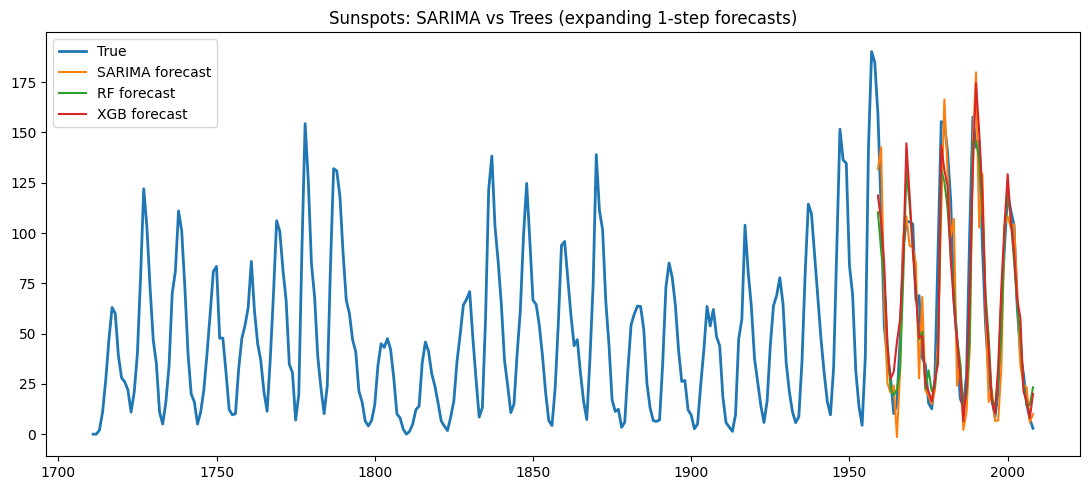

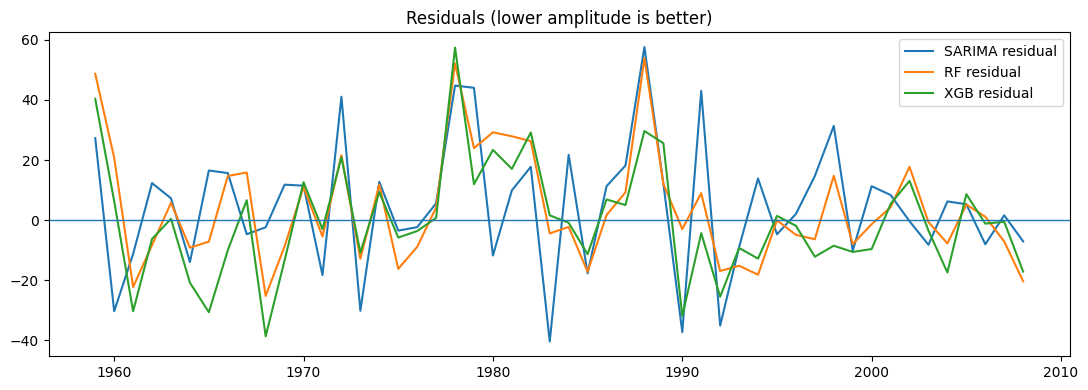

In [3]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ---------- 1) Load real data ----------
data = sm.datasets.sunspots.load_pandas().data  # columns: YEAR, SUNACTIVITY
df = data.rename(columns={"SUNACTIVITY": "y", "YEAR": "t"})
df = df[(df["t"] >= 1700) & (df["t"] <= 2008)].reset_index(drop=True)  # a standard range

# ---------- 2) Feature engineering for trees ----------
def make_features(df, max_lag=11, roll_windows=(5, 11), period=11):
    out = df.copy()
    for L in range(1, max_lag+1):
        out[f"lag_{L}"] = out["y"].shift(L)
    for w in roll_windows:
        out[f"roll_mean_{w}"] = out["y"].shift(1).rolling(w).mean()
        out[f"roll_std_{w}"]  = out["y"].shift(1).rolling(w).std()
    out["sin1"] = np.sin(2*np.pi*out["t"]/period)
    out["cos1"] = np.cos(2*np.pi*out["t"]/period)
    return out

X = make_features(df).dropna().reset_index(drop=True)
features = [c for c in X.columns if c not in ["y","t"]]

# ---------- 3) Train/test split (last 50 obs = test) ----------
test_len = 50
split = len(X) - test_len
train0 = X.iloc[:split]
test0  = X.iloc[split:]

# ---------- 4) Walk-forward: SARIMA, RF, XGB ----------
y_true, y_arima, y_rf, y_xgb, tt = [], [], [], [], []

# Preallocate models/hypers
rf_params = dict(n_estimators=500, min_samples_leaf=4, random_state=42, n_jobs=-1)
# Simple seasonal-ish SARIMA: p,d,q × (P,D,Q, s=11)
sarima_order = (2,0,2)
sarima_seasonal = (1,0,0,11)

try:
    from xgboost import XGBRegressor
    use_xgb = True
    xgb_params = dict(
        n_estimators=600, learning_rate=0.05, max_depth=5,
        subsample=0.8, colsample_bytree=0.9, reg_lambda=2.0,
        random_state=42, objective="reg:squarederror", verbosity=0
    )
except Exception:
    use_xgb = False

# Start walk-forward at first test index in X (expanding window, 1-step ahead)
start_idx = split
for i in range(start_idx, len(X)):
    train = X.iloc[:i]
    test_row = X.iloc[i:i+1]
    y_true.append(test_row["y"].item())
    tt.append(int(test_row["t"].item()))

    # ----- SARIMA on original series (up to i-1) -----
    series_train = X.iloc[:i]["y"]
    sarima = sm.tsa.statespace.SARIMAX(
        series_train,
        order=sarima_order,
        seasonal_order=sarima_seasonal,
        enforce_stationarity=False,
        enforce_invertibility=False,
    ).fit(disp=False)
    fc_arima = sarima.forecast(1).iloc[0]
    y_arima.append(fc_arima)

    # ----- Random Forest on lagged features -----
    rf = RandomForestRegressor(**rf_params)
    rf.fit(train[features], train["y"])
    y_rf.append(rf.predict(test_row[features])[0])

    # ----- XGBoost (optional) -----
    if use_xgb:
        xgb = XGBRegressor(**xgb_params)
        xgb.fit(train[features], train["y"])
        y_xgb.append(xgb.predict(test_row[features])[0])

# Convert to arrays
y_true = np.array(y_true); y_arima = np.array(y_arima); y_rf = np.array(y_rf)
if use_xgb: y_xgb = np.array(y_xgb)

# ---------- 5) Metrics ----------
def metrics(y, yhat):
    mae = float(mean_absolute_error(y, yhat))
    rmse = float(np.sqrt(mean_squared_error(y, yhat)))
    return mae, rmse

mae_a, rmse_a = metrics(y_true, y_arima)
mae_r, rmse_r = metrics(y_true, y_rf)
print(f"SARIMA  MAE={mae_a:.3f}  RMSE={rmse_a:.3f}")
print(f"RF      MAE={mae_r:.3f}  RMSE={rmse_r:.3f}")
if use_xgb:
    mae_x, rmse_x = metrics(y_true, y_xgb)
    print(f"XGB     MAE={mae_x:.3f}  RMSE={rmse_x:.3f}")

# ---------- 6) Plots ----------
plt.figure(figsize=(11,5))
plt.plot(X["t"], X["y"], label="True", lw=2)
plt.plot(tt, y_arima, label="SARIMA forecast")
plt.plot(tt, y_rf, label="RF forecast")
if use_xgb: plt.plot(tt, y_xgb, label="XGB forecast")
plt.title("Sunspots: SARIMA vs Trees (expanding 1-step forecasts)")
plt.legend(); plt.tight_layout(); plt.show()

# Residual comparison
plt.figure(figsize=(11,4))
plt.plot(tt, y_true - y_arima, label="SARIMA residual")
plt.plot(tt, y_true - y_rf, label="RF residual")
if use_xgb: plt.plot(tt, y_true - y_xgb, label="XGB residual")
plt.axhline(0, lw=1); plt.title("Residuals (lower amplitude is better)")
plt.legend(); plt.tight_layout(); plt.show()


[BASELINE]  RMSE=574.416  MAPE=3.81%  (valid)


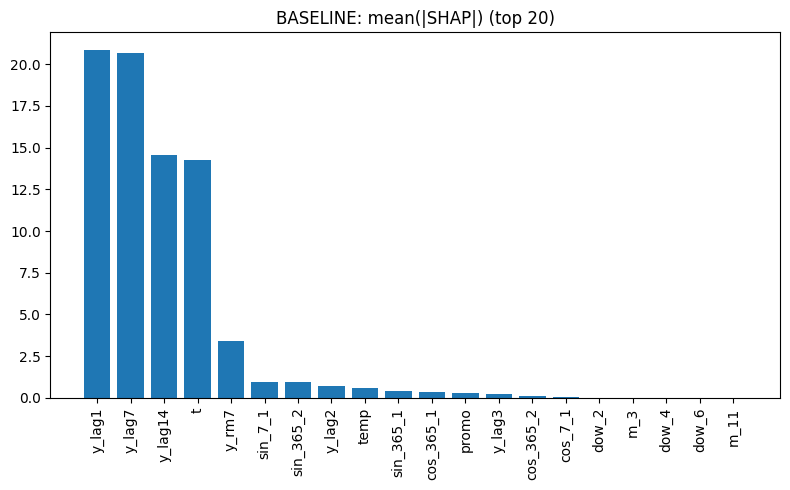

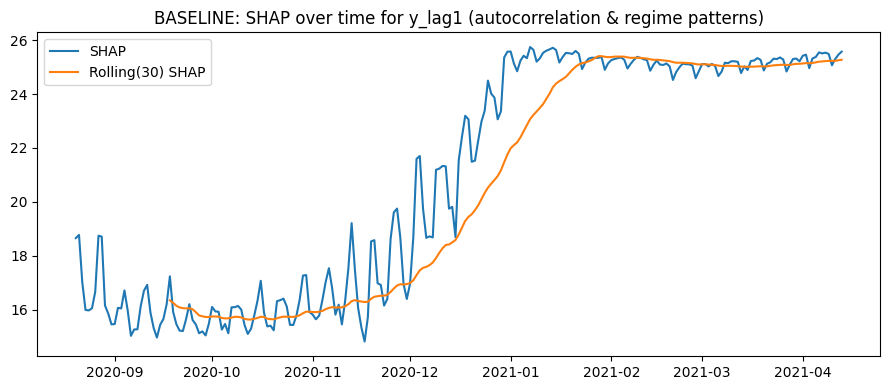

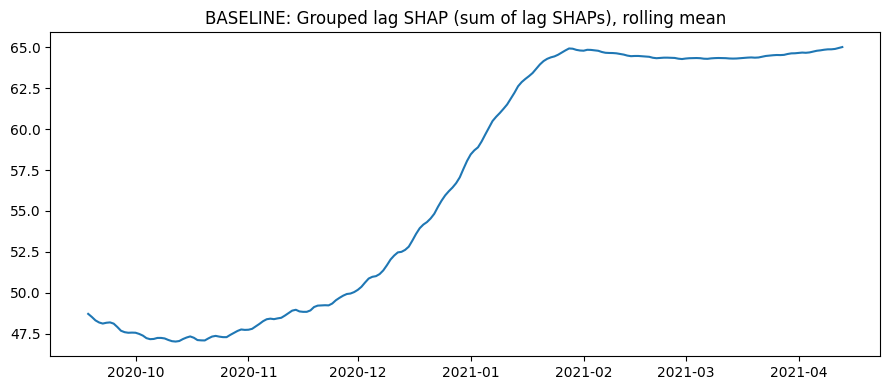

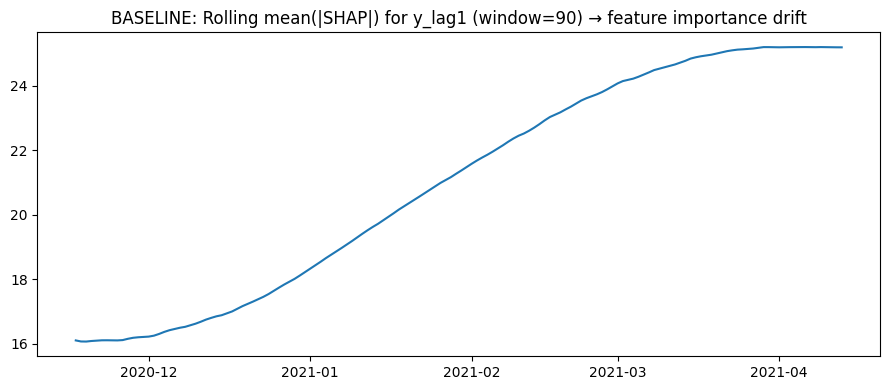

[LEAKAGE]  RMSE=449.771  MAPE=3.11%  (valid)


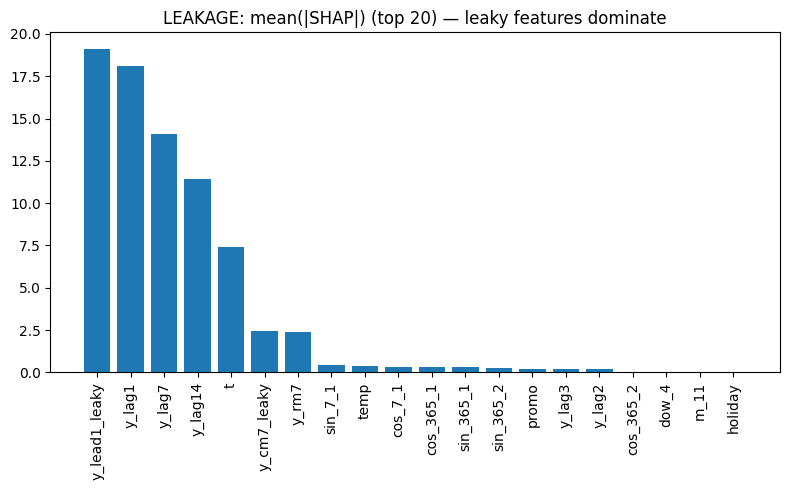

[TREND_HEAVY]  RMSE=968.720  MAPE=5.72%  (valid)


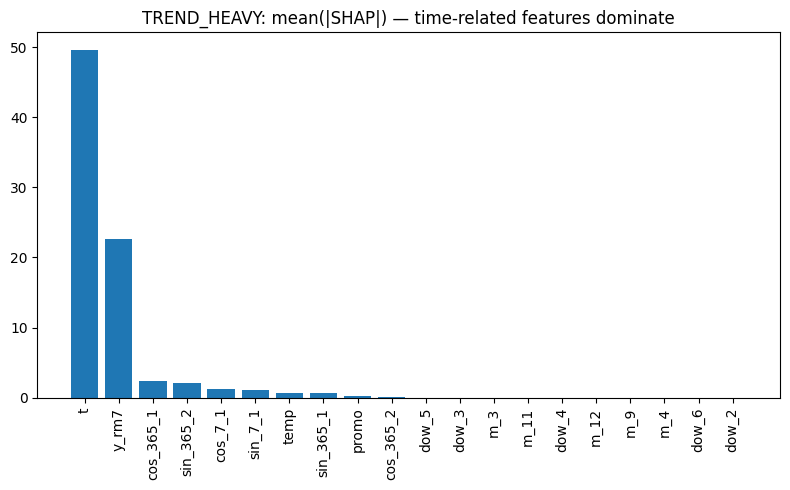

[DETRENDED]  RMSE=1.865  MAPE=172.14%  (valid)


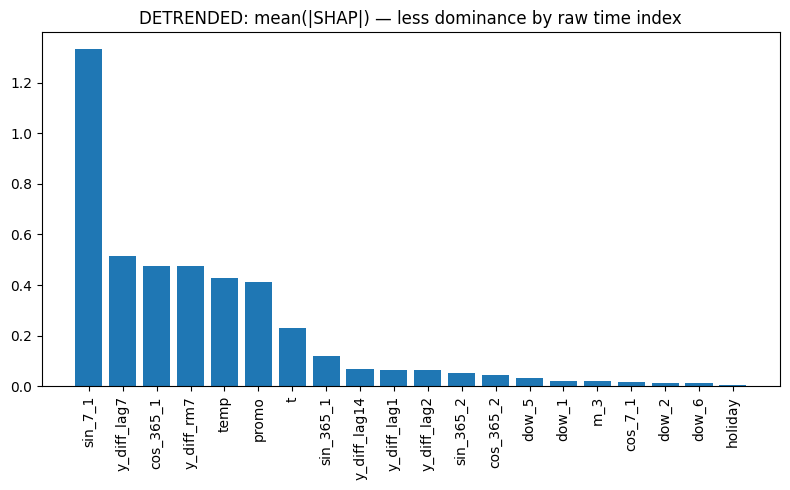

[Conditional SHAP] mean(|SHAP|) for 'promo': holiday=0.7575 vs normal=0.2076


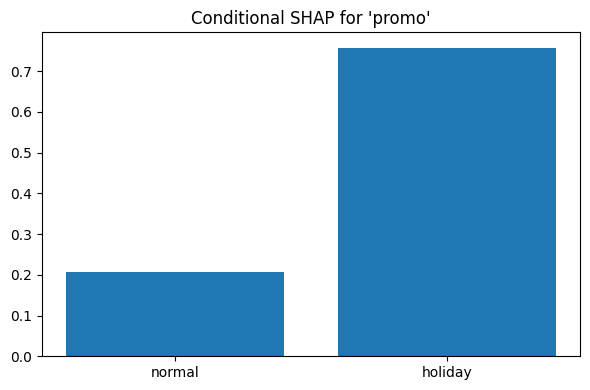

[WIN_A]  RMSE=3128.617  MAPE=12.68%  (valid)
[WIN_B]  RMSE=558.559  MAPE=3.89%  (valid)
[Model comparability] mean(|SHAP|) for y_lag1 → WIN_A=18.8619  vs  WIN_B=14.7078


In [10]:
# =========================
# XGBoost + SHAP for Time Series
# Pitfalls Demonstration
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# --- Make sure these are installed in your environment ---
import xgboost as xgb
import shap

np.random.seed(42)

# ---------------------------
# 1) Generate a synthetic time series with exogenous drivers
# ---------------------------
N = 1200
dates = pd.date_range("2018-01-01", periods=N, freq="D")
t = np.arange(N)

# Exogenous: temperature (yearly sinus + noise), promo (spikes), holiday (seasonal window)
temp = 10 + 10*np.sin(2*np.pi*t/365.25) + np.random.normal(0, 1.0, N)
holiday = ((dates.month==12) & (dates.day>=15)) | ((dates.month==1) & (dates.day<=7))
holiday = holiday.astype(int)

# promotions are more likely during holidays
promo = (np.random.binomial(1, p=0.06, size=N) | (holiday & (np.random.rand(N) < 0.4))).astype(int)

# Weekly seasonality
weekly = 2.0 * np.sin(2*np.pi*t/7.0)

# Base trend
trend = 0.02 * t

# AR component: y_t depends on y_{t-1}, y_{t-7}
y = np.zeros(N)
eps = np.random.normal(0, 1.2, N)

for i in range(N):
    lag1 = y[i-1] if i-1 >= 0 else 0.0
    lag7 = y[i-7] if i-7 >= 0 else 0.0
    y[i] = (20
            + 0.65*lag1
            + 0.25*lag7
            + 0.30*temp[i]
            + 2.50*promo[i]
            + weekly[i]
            + 0.8*trend[i]
            + eps[i])

df = pd.DataFrame({
    "ds": dates,
    "y": y,
    "temp": temp,
    "promo": promo,
    "holiday": holiday,
})
df["t"] = np.arange(len(df))  # time index

# Fourier terms (can be collinear with month/season dummies)
def fourier_series(n, period, K=3):
    x = np.arange(n)
    cols = {}
    for k in range(1, K+1):
        cols[f'sin_{period}_{k}'] = np.sin(2*np.pi*k*x/period)
        cols[f'cos_{period}_{k}'] = np.cos(2*np.pi*k*x/period)
    return pd.DataFrame(cols)

fs_year = fourier_series(N, period=365, K=2).reset_index(drop=True)
fs_week = fourier_series(N, period=7,   K=1).reset_index(drop=True)

df = pd.concat([df.reset_index(drop=True), fs_year, fs_week], axis=1)

# ---------------------------
# 2) Feature engineering (lags, rolling means, leakage variants)
# ---------------------------
def add_lags(frame, col="y", lags=(1,2,3,7,14)):
    out = frame.copy()
    for L in lags:
        out[f"{col}_lag{L}"] = out[col].shift(L)
    return out

def add_rolls(frame, col="y"):
    out = frame.copy()
    # causal trailing mean (safe)
    out["y_rm7"] = out[col].rolling(7, min_periods=1).mean().shift(1)
    # centered rolling mean (LEAKS future)
    out["y_cm7_leaky"] = out[col].rolling(7, center=True, min_periods=1).mean()
    # explicit lead (LEAKS future)
    out["y_lead1_leaky"] = out[col].shift(-1)
    return out

df = add_lags(df, "y", lags=(1,2,3,7,14))
df = add_rolls(df, "y")

# month/day-of-week dummies (can confound with Fourier)
df["month"] = df["ds"].dt.month
df["dow"] = df["ds"].dt.dayofweek
month_dum = pd.get_dummies(df["month"], prefix="m", drop_first=True)
dow_dum   = pd.get_dummies(df["dow"],   prefix="dow", drop_first=True)

df = pd.concat([df, month_dum, dow_dum], axis=1)

# Drop initial NA from lags
df = df.dropna().reset_index(drop=True)

# ---------------------------
# 3) Train/validation split by time
# ---------------------------
split_idx = int(len(df) * 0.8)
train = df.iloc[:split_idx].copy()
valid = df.iloc[split_idx:].copy()

# Helper: train + evaluate + get SHAP
def train_xgb_get_shap(X_train, y_train, X_valid, y_valid, model_name="model", max_depth=4):
    model = xgb.XGBRegressor(
        n_estimators=400,
        max_depth=max_depth,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        tree_method="hist",
        random_state=42
    )
    model.fit(X_train, y_train)
    pred = model.predict(X_valid)
    rmse = mean_squared_error(y_valid, pred)
    mape = mean_absolute_percentage_error(y_valid, pred)

    explainer = shap.TreeExplainer(model)
    shap_values = explainer(X_valid)

    print(f"[{model_name}]  RMSE={rmse:.3f}  MAPE={100*mape:.2f}%  (valid)")
    return model, shap_values, pred

def bar_mean_abs_shap(shap_values, feature_names, title):
    vals = np.abs(shap_values.values).mean(axis=0)
    order = np.argsort(vals)[::-1]
    topn = min(20, len(feature_names))
    plt.figure(figsize=(8,5))
    plt.bar(range(topn), vals[order][:topn])
    plt.xticks(range(topn), np.array(feature_names)[order][:topn], rotation=90)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_shap_time(series_time, shap_series, title, roll=30):
    plt.figure(figsize=(9,4))
    plt.plot(series_time, shap_series, label="SHAP")
    plt.plot(series_time, pd.Series(shap_series).rolling(roll).mean(), label=f"Rolling({roll}) SHAP")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---------------------------
# 4) BASELINE (CAUSAL) MODEL
#    Demonstrates: lag multicollinearity, grouped SHAP, SHAP autocorrelation, drift
# ---------------------------
causal_features = (
    ["temp","promo","holiday","t","y_rm7",
     "y_lag1","y_lag2","y_lag3","y_lag7","y_lag14",
     "sin_365_1","cos_365_1","sin_365_2","cos_365_2",
     "sin_7_1","cos_7_1"]
    + [c for c in df.columns if c.startswith("m_")]
    + [c for c in df.columns if c.startswith("dow_")]
)

X_train = train[causal_features]
y_train = train["y"]
X_valid = valid[causal_features]
y_valid = valid["y"]

m_base, shap_base, yhat_base = train_xgb_get_shap(X_train, y_train, X_valid, y_valid, "BASELINE")

# Global mean(|SHAP|) bar: shows which features the model uses (can obscure lag group split)
bar_mean_abs_shap(shap_base, X_valid.columns, "BASELINE: mean(|SHAP|) (top 20)")

# Time plot of SHAP for a specific lag to show autocorrelation & smoothing
shap_df_base = pd.DataFrame(shap_base.values, columns=X_valid.columns, index=valid["ds"])
plot_shap_time(
    valid["ds"],
    shap_df_base["y_lag1"].values,
    "BASELINE: SHAP over time for y_lag1 (autocorrelation & regime patterns)",
    roll=30
)

# Group lag SHAPs to address multicollinearity "credit splitting"
lag_cols = [c for c in X_valid.columns if c.startswith("y_lag")]
shap_df_base["lag_block_SHAP"] = shap_df_base[lag_cols].sum(axis=1)

plt.figure(figsize=(9,4))
plt.plot(valid["ds"], shap_df_base["lag_block_SHAP"].rolling(30).mean())
plt.title("BASELINE: Grouped lag SHAP (sum of lag SHAPs), rolling mean")
plt.tight_layout(); plt.show()

# Drift: rolling importance of a single feature (mean |SHAP| in a sliding window)
win = 90
abs_lag1 = np.abs(shap_df_base["y_lag1"])
roll_imp = abs_lag1.rolling(win).mean()
plt.figure(figsize=(9,4))
plt.plot(valid["ds"], roll_imp)
plt.title(f"BASELINE: Rolling mean(|SHAP|) for y_lag1 (window={win}) → feature importance drift")
plt.tight_layout(); plt.show()

# ---------------------------
# 5) LEAKAGE MODEL
#    Adds y_lead1_leaky and centered rolling mean y_cm7_leaky
#    Demonstrates: leakage inflates performance & SHAP for leaky features
# ---------------------------
leak_features = causal_features + ["y_lead1_leaky", "y_cm7_leaky"]

X_train_leak = train[leak_features].copy()
X_valid_leak = valid[leak_features].copy()

m_leak, shap_leak, yhat_leak = train_xgb_get_shap(X_train_leak, y_train, X_valid_leak, y_valid, "LEAKAGE")

# Compare performance: leakage should look unrealistically good
bar_mean_abs_shap(shap_leak, X_valid_leak.columns, "LEAKAGE: mean(|SHAP|) (top 20) — leaky features dominate")

# ---------------------------
# 6) TREND CONFOUNDING vs DETRENDING
#    (A) Add strong time index and month dummies → time absorbs patterns
#    (B) Detrend target and refit
# ---------------------------
# (A) Trend-heavy spec (already had 't' + month/dow; reinforce by removing some lags)
trend_spec = [
    "temp","promo","holiday","t","y_rm7",
    "sin_365_1","cos_365_1","sin_365_2","cos_365_2","sin_7_1","cos_7_1"
] + [c for c in df.columns if c.startswith("m_")] + [c for c in df.columns if c.startswith("dow_")]

X_train_trend = train[trend_spec]
X_valid_trend = valid[trend_spec]
m_trend, shap_trend, yhat_trend = train_xgb_get_shap(X_train_trend, y_train, X_valid_trend, y_valid, "TREND_HEAVY")

bar_mean_abs_shap(shap_trend, X_valid_trend.columns, "TREND_HEAVY: mean(|SHAP|) — time-related features dominate")

# (B) Detrend target (simple differencing)
df["y_diff"] = df["y"].diff()
df2 = df.dropna().reset_index(drop=True)
split_idx2 = int(len(df2)*0.8)
train2 = df2.iloc[:split_idx2].copy()
valid2 = df2.iloc[split_idx2:].copy()

# Use differenced-compatible features (lags of y_diff + exogenous at t, causal rolls)
def add_diff_lags(frame, col="y_diff", lags=(1,2,7,14)):
    out = frame.copy()
    for L in lags:
        out[f"{col}_lag{L}"] = out[col].shift(L)
    return out

df2 = add_diff_lags(df2, "y_diff", lags=(1,2,7,14))
df2["y_diff_rm7"] = df2["y_diff"].rolling(7, min_periods=1).mean().shift(1)
df2 = df2.dropna().reset_index(drop=True)

split_idx3 = int(len(df2)*0.8)
train3 = df2.iloc[:split_idx3].copy()
valid3 = df2.iloc[split_idx3:].copy()

detrend_feats = [
    "temp","promo","holiday","t","y_diff_rm7",
    "y_diff_lag1","y_diff_lag2","y_diff_lag7","y_diff_lag14",
    "sin_365_1","cos_365_1","sin_365_2","cos_365_2","sin_7_1","cos_7_1"
] + [c for c in df2.columns if c.startswith("m_")] + [c for c in df2.columns if c.startswith("dow_")]

X_train_det = train3[detrend_feats]
y_train_det = train3["y_diff"]
X_valid_det = valid3[detrend_feats]
y_valid_det = valid3["y_diff"]

m_det, shap_det, yhat_det = train_xgb_get_shap(X_train_det, y_train_det, X_valid_det, y_valid_det, "DETRENDED")

bar_mean_abs_shap(shap_det, X_valid_det.columns, "DETRENDED: mean(|SHAP|) — less dominance by raw time index")

# ---------------------------
# 7) Conditional (Regime) SHAP: holiday vs non-holiday
# ---------------------------
valid_mask = df.index.isin(valid.index)  # alignment for baseline window
valid_holiday_idx = valid.index[valid["holiday"]==1]
valid_normal_idx  = valid.index[valid["holiday"]==0]

# Align SHAP frame for baseline
shap_df_base = pd.DataFrame(shap_base.values, columns=X_valid.columns, index=valid.index)

feat = "promo"
promo_shap_hol = np.abs(shap_df_base.loc[valid_holiday_idx, feat]).mean()
promo_shap_norm = np.abs(shap_df_base.loc[valid_normal_idx,  feat]).mean()

print(f"[Conditional SHAP] mean(|SHAP|) for '{feat}': holiday={promo_shap_hol:.4f} vs normal={promo_shap_norm:.4f}")

plt.figure(figsize=(6,4))
plt.bar([0,1], [promo_shap_norm, promo_shap_hol])
plt.xticks([0,1], ["normal","holiday"])
plt.title("Conditional SHAP for 'promo'")
plt.tight_layout(); plt.show()

# ---------------------------
# 8) Model version comparability caveat:
#    Compare global SHAP for lag1 across two different training windows
# ---------------------------
# Earlier 60% vs later 60% windows (overlapping with valid)
cut_A = int(len(df)*0.6)
cut_B = int(len(df)*0.6)

train_A = df.iloc[:cut_A].dropna()
valid_A = df.iloc[cut_A:].dropna()
train_B = df.iloc[int(len(df)*0.2):int(len(df)*0.8)].dropna()
valid_B = df.iloc[int(len(df)*0.8):].dropna()

def fit_and_global_shap(train_df, valid_df, feats, tag):
    XA, yA = train_df[feats], train_df["y"]
    XV, yV = valid_df[feats], valid_df["y"]
    m, sh, _ = train_xgb_get_shap(XA, yA, XV, yV, tag, max_depth=4)
    sh_df = pd.DataFrame(np.abs(sh.values), columns=XV.columns)
    return sh_df.mean()

gA = fit_and_global_shap(train_A, valid_A, causal_features, "WIN_A")
gB = fit_and_global_shap(train_B, valid_B, causal_features, "WIN_B")

# Compare the global mean(|SHAP|) for y_lag1 across model versions
print(f"[Model comparability] mean(|SHAP|) for y_lag1 → WIN_A={gA.get('y_lag1', np.nan):.4f}  vs  WIN_B={gB.get('y_lag1', np.nan):.4f}")


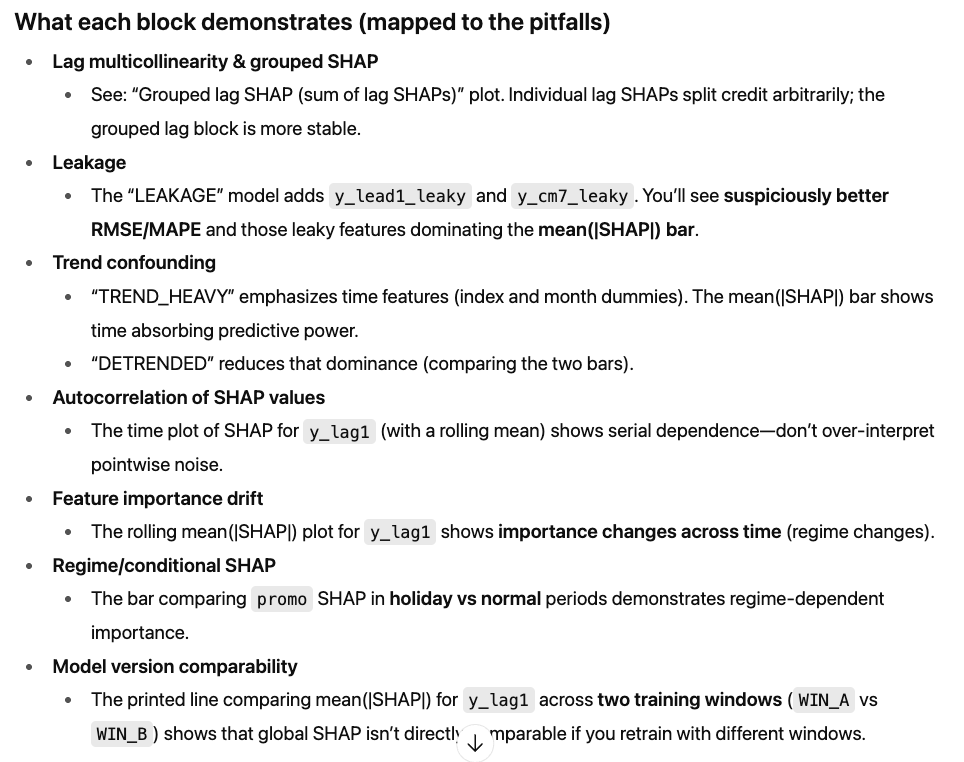